삭제된 포스트 체크 하는 파일 

* 이슈  
    * postwithdeleted테이블에는 있지만 db에 있는 post테이블에는 없는 질의 응답 존재 
    * 예시 아이디 > 2335608
    * db에 있는 데이터와 SEDE에 있는 데이터를 짬뽕해서는 숫자를 맞출 수 없음 
    * 그래서 SEDE에 있는 데이터 만드로 확인 

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
import re
from collections import deque
import datetime
import matplotlib.dates as mdates

In [2]:
postwithdeleted = pd.read_csv('../../data/postwithdeleted.csv')

In [3]:
postwithdeleted_pertype = pd.read_csv('../../data/postwithdeleted_pertype.csv')

In [4]:
deletedwithin = pd.read_csv('../../data/deletedwithin.csv')
totdeletedwithin = pd.read_csv('../../data/totdeletedwithin.csv')


In [5]:
deletedATags = pd.read_csv('../../data/deletedATags.csv')

In [6]:
deletedQTags = pd.read_csv('../../data/deletedQTags.csv')

In [7]:
# 파일 불러오기
with open('../../data/df_body.pkl', 'rb') as f:
    df_body = pickle.load(f)


In [8]:
with open('../../data/top50_tags_in_2022_2023.pkl', 'rb') as f:
    top50_tags = pickle.load(f)
# from /Users/cslab/code-server/Myokyung/stackoverflow_src/DA/1_visualization.ipynb 


In [9]:
top50_tags

{'python': 179328,
 'javascript': 117433,
 'reactjs': 61529,
 'java': 50309,
 'c#': 46727,
 'html': 44611,
 'r': 37630,
 'pandas': 37283,
 'css': 32862,
 'flutter': 31686,
 'sql': 31411,
 'android': 29815,
 'node.js': 29768,
 'c++': 27255,
 'typescript': 26950,
 'php': 25992,
 'python-3.x': 23852,
 'dataframe': 22384,
 'arrays': 22006,
 'angular': 17902,
 'django': 17620,
 'json': 16962,
 'dart': 16872,
 'mysql': 16209,
 'c': 15741,
 'excel': 13748,
 'laravel': 13287,
 'swift': 13016,
 'spring-boot': 13010,
 'amazon-web-services': 12949,
 'react-native': 12694,
 'postgresql': 12503,
 'azure': 12178,
 'kotlin': 12172,
 'docker': 11835,
 'list': 11442,
 'firebase': 10964,
 'ios': 10889,
 'sql-server': 10442,
 'jquery': 10415,
 'mongodb': 10367,
 'vue.js': 10108,
 'numpy': 9377,
 '.net': 9298,
 'vba': 8921,
 'regex': 8767,
 'string': 8586,
 'spring': 8528,
 'powershell': 8264,
 'linux': 8251,
 'next.js': 7011,
 'rust': 4591,
 'visual-studio-code': 4546,
 'asp.net-core': 4463}

In [10]:
old_col = list(top50_tags.keys())[:50]
new_col = [ x.replace('.', '').replace('-', '_').replace('+', 'plus') for x in old_col]


In [11]:
col_dict = { x.replace('.', '').replace('-', '_').replace('+', 'plus') : x for x in list(top50_tags.keys())[:50]}

In [12]:
col_dict

{'python': 'python',
 'javascript': 'javascript',
 'reactjs': 'reactjs',
 'java': 'java',
 'c#': 'c#',
 'html': 'html',
 'r': 'r',
 'pandas': 'pandas',
 'css': 'css',
 'flutter': 'flutter',
 'sql': 'sql',
 'android': 'android',
 'nodejs': 'node.js',
 'cplusplus': 'c++',
 'typescript': 'typescript',
 'php': 'php',
 'python_3x': 'python-3.x',
 'dataframe': 'dataframe',
 'arrays': 'arrays',
 'angular': 'angular',
 'django': 'django',
 'json': 'json',
 'dart': 'dart',
 'mysql': 'mysql',
 'c': 'c',
 'excel': 'excel',
 'laravel': 'laravel',
 'swift': 'swift',
 'spring_boot': 'spring-boot',
 'amazon_web_services': 'amazon-web-services',
 'react_native': 'react-native',
 'postgresql': 'postgresql',
 'azure': 'azure',
 'kotlin': 'kotlin',
 'docker': 'docker',
 'list': 'list',
 'firebase': 'firebase',
 'ios': 'ios',
 'sql_server': 'sql-server',
 'jquery': 'jquery',
 'mongodb': 'mongodb',
 'vuejs': 'vue.js',
 'numpy': 'numpy',
 'net': '.net',
 'vba': 'vba',
 'regex': 'regex',
 'string': 'string',

In [13]:
' '.join(["case when b.tags like '%<"+ col_dict[x] +">%' then 1 else 0 end as "+x+"_yn, " for x in new_col])

"case when b.tags like '%<python>%' then 1 else 0 end as python_yn,  case when b.tags like '%<javascript>%' then 1 else 0 end as javascript_yn,  case when b.tags like '%<reactjs>%' then 1 else 0 end as reactjs_yn,  case when b.tags like '%<java>%' then 1 else 0 end as java_yn,  case when b.tags like '%<c#>%' then 1 else 0 end as c#_yn,  case when b.tags like '%<html>%' then 1 else 0 end as html_yn,  case when b.tags like '%<r>%' then 1 else 0 end as r_yn,  case when b.tags like '%<pandas>%' then 1 else 0 end as pandas_yn,  case when b.tags like '%<css>%' then 1 else 0 end as css_yn,  case when b.tags like '%<flutter>%' then 1 else 0 end as flutter_yn,  case when b.tags like '%<sql>%' then 1 else 0 end as sql_yn,  case when b.tags like '%<android>%' then 1 else 0 end as android_yn,  case when b.tags like '%<node.js>%' then 1 else 0 end as nodejs_yn,  case when b.tags like '%<c++>%' then 1 else 0 end as cplusplus_yn,  case when b.tags like '%<typescript>%' then 1 else 0 end as typescript

In [14]:
# or b.tags like '%<amazon-web-services>%'
' '.join([" or b.tags like '%<"+ col_dict[x] +">%'" for x in new_col])

" or b.tags like '%<python>%'  or b.tags like '%<javascript>%'  or b.tags like '%<reactjs>%'  or b.tags like '%<java>%'  or b.tags like '%<c#>%'  or b.tags like '%<html>%'  or b.tags like '%<r>%'  or b.tags like '%<pandas>%'  or b.tags like '%<css>%'  or b.tags like '%<flutter>%'  or b.tags like '%<sql>%'  or b.tags like '%<android>%'  or b.tags like '%<node.js>%'  or b.tags like '%<c++>%'  or b.tags like '%<typescript>%'  or b.tags like '%<php>%'  or b.tags like '%<python-3.x>%'  or b.tags like '%<dataframe>%'  or b.tags like '%<arrays>%'  or b.tags like '%<angular>%'  or b.tags like '%<django>%'  or b.tags like '%<json>%'  or b.tags like '%<dart>%'  or b.tags like '%<mysql>%'  or b.tags like '%<c>%'  or b.tags like '%<excel>%'  or b.tags like '%<laravel>%'  or b.tags like '%<swift>%'  or b.tags like '%<spring-boot>%'  or b.tags like '%<amazon-web-services>%'  or b.tags like '%<react-native>%'  or b.tags like '%<postgresql>%'  or b.tags like '%<azure>%'  or b.tags like '%<kotlin>%'  o

In [15]:
# sum(x.net_yn) as net,
' '.join([" sum(x."+ x +"_yn) as "+x+"," for x in new_col])

' sum(x.python_yn) as python,  sum(x.javascript_yn) as javascript,  sum(x.reactjs_yn) as reactjs,  sum(x.java_yn) as java,  sum(x.c#_yn) as c#,  sum(x.html_yn) as html,  sum(x.r_yn) as r,  sum(x.pandas_yn) as pandas,  sum(x.css_yn) as css,  sum(x.flutter_yn) as flutter,  sum(x.sql_yn) as sql,  sum(x.android_yn) as android,  sum(x.nodejs_yn) as nodejs,  sum(x.cplusplus_yn) as cplusplus,  sum(x.typescript_yn) as typescript,  sum(x.php_yn) as php,  sum(x.python_3x_yn) as python_3x,  sum(x.dataframe_yn) as dataframe,  sum(x.arrays_yn) as arrays,  sum(x.angular_yn) as angular,  sum(x.django_yn) as django,  sum(x.json_yn) as json,  sum(x.dart_yn) as dart,  sum(x.mysql_yn) as mysql,  sum(x.c_yn) as c,  sum(x.excel_yn) as excel,  sum(x.laravel_yn) as laravel,  sum(x.swift_yn) as swift,  sum(x.spring_boot_yn) as spring_boot,  sum(x.amazon_web_services_yn) as amazon_web_services,  sum(x.react_native_yn) as react_native,  sum(x.postgresql_yn) as postgresql,  sum(x.azure_yn) as azure,  sum(x.kotli

In [16]:
df_body['date'] = df_body['creationdate'].dt.date
df_body['year'] = df_body['creationdate'].dt.year
df_body['month'] = df_body['creationdate'].dt.month
df_body['day'] = df_body['creationdate'].dt.day

In [17]:
# Q&A 만 추출 
df_body = df_body[df_body['posttypeid'].isin(['1','2'])]
df_qna_num = df_body.groupby(['date', 'posttypeid']).count()[['id']].reset_index()

In [18]:
df_bodycnt = df_body.groupby(['date', 'posttypeid']).count()[['id']].reset_index()

In [19]:
df_bodycnt = pd.pivot_table(df_bodycnt, index = 'date', columns = 'posttypeid', values = 'id').reset_index()

In [20]:
df_bodycnt

posttypeid,date,1,2
0,2013-11-01,5614.0,9372.0
1,2013-11-02,3314.0,5248.0
2,2013-11-03,3537.0,5489.0
3,2013-11-04,6188.0,9585.0
4,2013-11-05,6566.0,10671.0
...,...,...,...
3677,2023-11-26,1811.0,1522.0
3678,2023-11-27,3201.0,2601.0
3679,2023-11-28,3416.0,2809.0
3680,2023-11-29,3519.0,2869.0


In [21]:
postwithdeleted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22412 entries, 0 to 22411
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   date        22412 non-null  object
 1   posttypeid  22412 non-null  int64 
 2   del_yn      22412 non-null  object
 3   tot_cnt     22412 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 700.5+ KB


In [22]:
postwithdeleted['date_mod'] = pd.to_datetime(postwithdeleted['date'])


In [23]:
postwithdeleted = postwithdeleted.sort_values(by = ['date_mod'], ascending=True).reset_index(drop=True)

In [24]:
postwithdeleted_pivot = pd.pivot_table(data = postwithdeleted, index='date_mod', columns=['posttypeid', 'del_yn'], values = ['tot_cnt']).reset_index()

In [25]:
postwithdeleted_pivot.head()

date_mod tot_cnt                    
posttypeid                  1            2       
del_yn                      N     Y      N      Y
0          2008-07-31     4.0   2.0    2.0    4.0
1          2008-08-01    48.0  14.0   89.0  112.0
2          2008-08-02    25.0  22.0   68.0  197.0
3          2008-08-03    33.0  21.0   97.0  158.0
4          2008-08-04    77.0  49.0  238.0  465.0

In [26]:
postwithdeleted_pivot.columns

MultiIndex([('date_mod', '',  ''),
            ( 'tot_cnt',  1, 'N'),
            ( 'tot_cnt',  1, 'Y'),
            ( 'tot_cnt',  2, 'N'),
            ( 'tot_cnt',  2, 'Y')],
           names=[None, 'posttypeid', 'del_yn'])

In [27]:
postwithdeleted_pivot.columns = ['date_mod', 'q_cnt', 'q_d_cnt', 'a_cnt', 'a_d_cnt']

In [28]:
postwithdeleted_pivot.head()

,date_mod,q_cnt,q_d_cnt,a_cnt,a_d_cnt
0,2008-07-31,4.0,2.0,2.0,4.0
1,2008-08-01,48.0,14.0,89.0,112.0
2,2008-08-02,25.0,22.0,68.0,197.0
3,2008-08-03,33.0,21.0,97.0,158.0
4,2008-08-04,77.0,49.0,238.0,465.0


In [29]:
postwithdeleted_pivot['tot_d_cnt'] = postwithdeleted_pivot['q_d_cnt']+postwithdeleted_pivot['a_d_cnt']
postwithdeleted_pivot['tot_qna_cnt'] = postwithdeleted_pivot['q_cnt']+postwithdeleted_pivot['a_cnt']

In [30]:
postwithdeleted_pivot['tot_q_cnt'] = postwithdeleted_pivot['q_cnt']+postwithdeleted_pivot['q_d_cnt']
postwithdeleted_pivot['tot_a_cnt'] = postwithdeleted_pivot['a_cnt']+postwithdeleted_pivot['a_d_cnt']

In [31]:
postwithdeleted_pivot['ad_over_qd'] = postwithdeleted_pivot['a_d_cnt']/ postwithdeleted_pivot['q_d_cnt']

In [32]:
postwithdeleted_pivot = postwithdeleted_pivot[postwithdeleted_pivot['date_mod']>='2013-11-30']

### Number of Deleted Answer over Number of Deleted Question

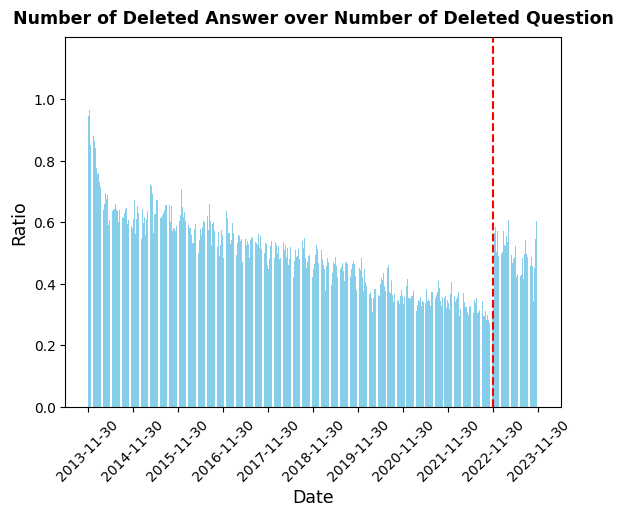

In [33]:
fig, ax = plt.subplots()


ax.bar(postwithdeleted_pivot.date_mod
    ,  height = postwithdeleted_pivot['ad_over_qd']
    ,  color = 'skyblue'
    ,  label = 'Mean'
    # ,  edgecolor = 'black'
      ) # hist type

ax.set_title("Number of Deleted Answer over Number of Deleted Question", # add title
             fontsize = 12.5,
             weight = 'bold',
             pad = 10,
             loc = 'center')
ax.set_xlabel("Date", # add x-axis label
              fontsize = 12.5)
ax.set_ylabel("Ratio", # add y-axis label
              fontsize = 12.5)

major_xticks = ['2013-11-30','2014-11-30','2015-11-30','2016-11-30','2017-11-30','2018-11-30','2019-11-30','2020-11-30'
                ,'2021-11-30', '2022-11-30', '2023-11-30']
ax.set_xticks(major_xticks)

ax.axvline(['2022-11-30'], # add vertical line
           color = 'red',
           linestyle = '--',
           linewidth = 1.5)
plt.xticks(rotation=45)
plt.show();

### Number of Question & Answer( Deleted+ Survived)

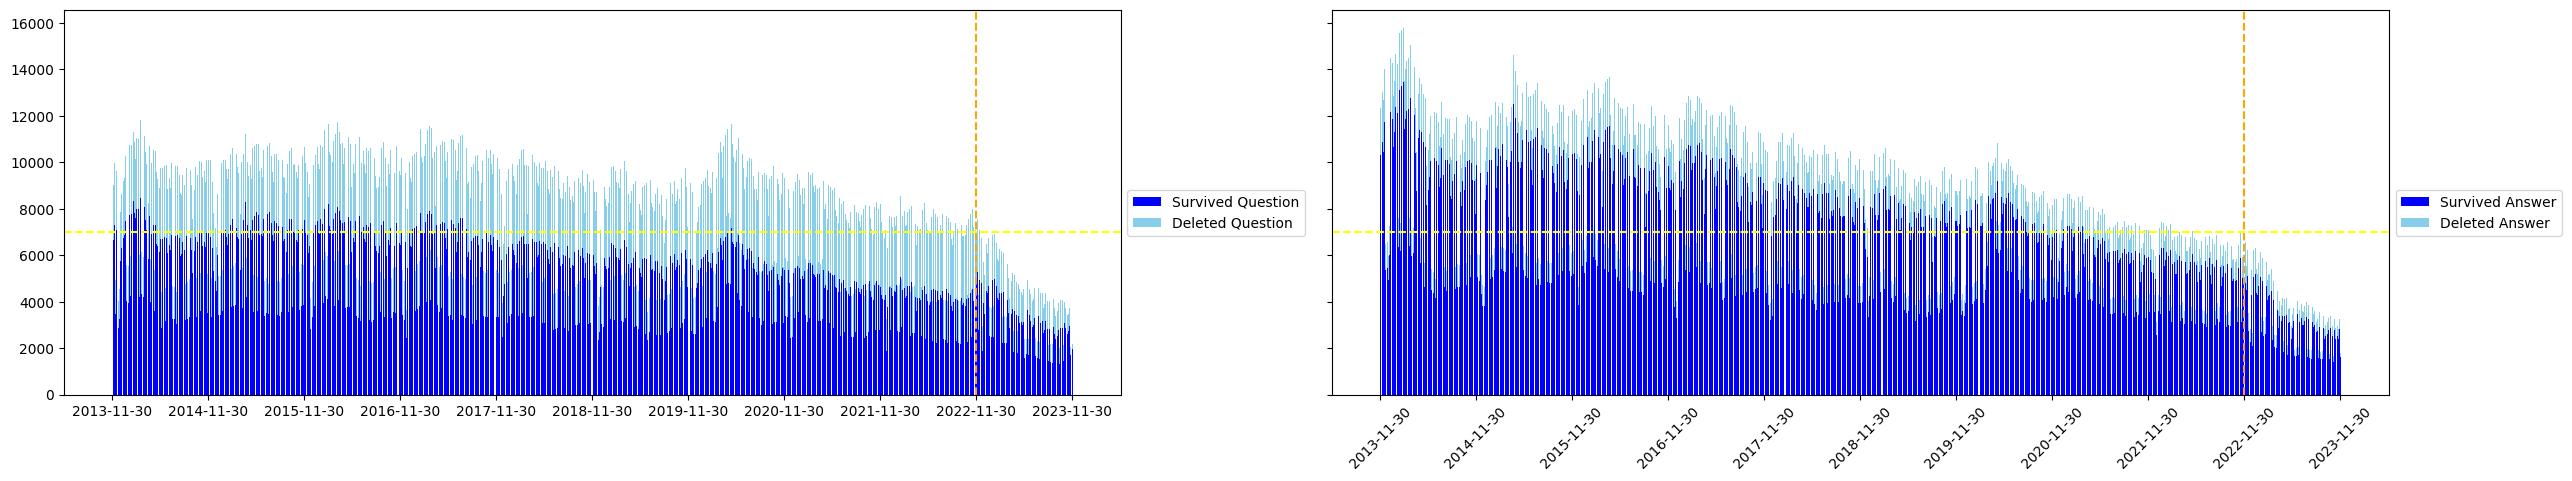

In [34]:
fig, ax = plt.subplots(1, 2, figsize = (30, 5), sharey=True, sharex=True)


major_xticks = ['2013-11-30','2014-11-30','2015-11-30','2016-11-30','2017-11-30','2018-11-30','2019-11-30','2020-11-30'
                ,'2021-11-30', '2022-11-30', '2023-11-30']

# ax.bar(topic_per_pivot['date'], topic_per_pivot[0], width = 0.5, color='blue', label = 'Party A')
ax[0].bar(postwithdeleted_pivot['date_mod'], postwithdeleted_pivot['q_cnt'], color='blue', label = 'Survived Question')
ax[0].bar(postwithdeleted_pivot['date_mod'], postwithdeleted_pivot['q_d_cnt'], bottom = postwithdeleted_pivot['q_cnt'], color = 'skyblue', label = 'Deleted Question')

ax[0].axvline([major_xticks[-2]], # add vertical line
           color = 'orange',
           linestyle = '--',
           linewidth = 1.5)
ax[0].set_xticks(major_xticks)
ax[0].axhline(7000, # add vertical line
           color = 'yellow',
           linestyle = '--',
           linewidth = 1.5)

ax[0].legend( title_fontsize = 10, fontsize = 10,
          bbox_to_anchor = (1, 0.55))


ax[1].bar(postwithdeleted_pivot['date_mod'], postwithdeleted_pivot['a_cnt'], color='blue', label = 'Survived Answer')
ax[1].bar(postwithdeleted_pivot['date_mod'], postwithdeleted_pivot['a_d_cnt'], bottom = postwithdeleted_pivot['a_cnt'], color = 'skyblue', label = 'Deleted Answer')

ax[1].axvline([major_xticks[-2]], # add vertical line
           color = 'orange',
           linestyle = '--',
           linewidth = 1.5)

ax[1].axhline(7000, # add vertical line
           color = 'yellow',
           linestyle = '--',
           linewidth = 1.5)
ax[1].set_xticks(major_xticks)
ax[1].legend( title_fontsize = 10, fontsize = 10,
          bbox_to_anchor = (1, 0.55))

plt.xticks(rotation = 45)
plt.show();
plt.show();

In [35]:
treat0 = postwithdeleted_pivot[(postwithdeleted_pivot['date_mod']>= '2021-10-06') & (postwithdeleted_pivot['date_mod']<= '2022-03-15')]

treat1 = postwithdeleted_pivot[(postwithdeleted_pivot['date_mod']>= '2022-10-05') & (postwithdeleted_pivot['date_mod']<= '2023-03-14')]


In [36]:
treat0

,date_mod,q_cnt,q_d_cnt,a_cnt,a_d_cnt,tot_d_cnt,tot_qna_cnt,tot_q_cnt,tot_a_cnt,ad_over_qd
4815,2021-10-06,4758.0,3414.0,6159.0,1118.0,4532.0,10917.0,8172.0,7277.0,0.327475
4816,2021-10-07,4644.0,3289.0,6046.0,1127.0,4416.0,10690.0,7933.0,7173.0,0.342657
4817,2021-10-08,4168.0,3076.0,5418.0,1059.0,4135.0,9586.0,7244.0,6477.0,0.344278
4818,2021-10-09,2491.0,1973.0,3339.0,762.0,2735.0,5830.0,4464.0,4101.0,0.386214
4819,2021-10-10,2535.0,1958.0,3299.0,684.0,2642.0,5834.0,4493.0,3983.0,0.349336
...,...,...,...,...,...,...,...,...,...,...
4971,2022-03-11,4247.0,3047.0,5351.0,1011.0,4058.0,9598.0,7294.0,6362.0,0.331802
4972,2022-03-12,2334.0,1766.0,2957.0,565.0,2331.0,5291.0,4100.0,3522.0,0.319932
4973,2022-03-13,2615.0,1940.0,3128.0,640.0,2580.0,5743.0,4555.0,3768.0,0.329897
4974,2022-03-14,4343.0,3181.0,5187.0,999.0,4180.0,9530.0,7524.0,6186.0,0.314052


In [37]:
treat0_list = [
 '2021-10-06',
 '2021-10-13',
 '2021-10-20',
 '2021-10-27',
 '2021-11-03',
 '2021-11-10',
 '2021-11-17',
 '2021-11-24',
 '2021-12-01',
 '2021-12-08',
 '2021-12-15',
 '2021-12-22',
 '2021-12-29',
 '2022-01-05',
 '2022-01-12',
 '2022-01-19',
 '2022-01-26',
 '2022-02-02',
 '2022-02-09',
 '2022-02-16',
 '2022-02-23',
 '2022-03-02',
 '2022-03-09']
treat1_list = ['2022-10-05',
 '2022-10-12',
 '2022-10-19',
 '2022-10-26',
 '2022-11-02',
 '2022-11-09',
 '2022-11-16',
 '2022-11-23',
 '2022-11-30',
 '2022-12-07',
 '2022-12-14',
 '2022-12-21',
 '2022-12-28',
 '2023-01-04',
 '2023-01-11',
 '2023-01-18',
 '2023-01-25',
 '2023-02-01',
 '2023-02-08',
 '2023-02-15',
 '2023-02-22',
 '2023-03-01',
 '2023-03-08']

In [38]:
treat0_list[8]

'2021-12-01'

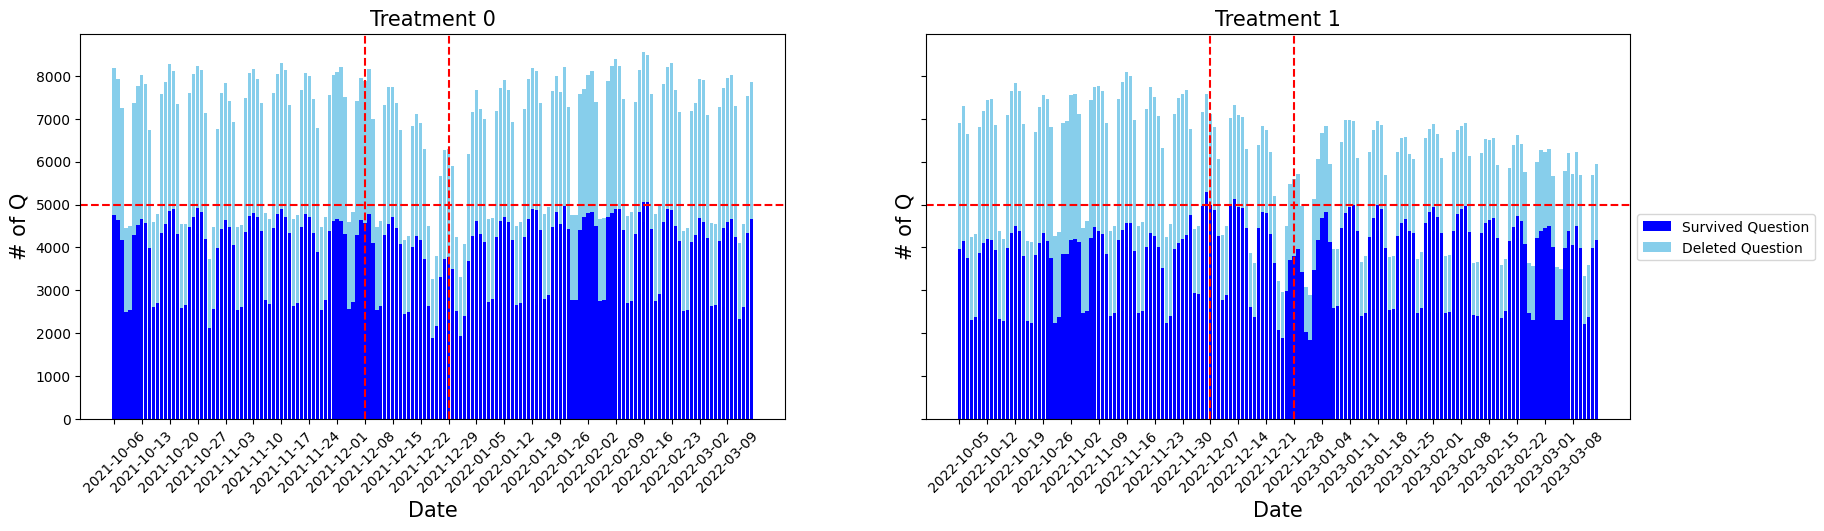

In [39]:
sharey = True ## 또는 sharey=False
sharex = True ## 또는 sharex=False

fig, axs = plt.subplots(1, 2, figsize = (20, 5), sharey=sharey, sharex=False)
# plt.xticks(rotation=45)
# yticks = np.arange(200, 2000, 400)

major_xticks = ['2021-10-06','2014-11-30','2015-11-30','2016-11-30','2017-11-30','2018-11-30','2019-11-30','2020-11-30'
                ,'2021-11-30', '2022-11-30', '2023-11-30']


axs[0].bar(treat0['date_mod'], treat0['q_cnt'], color='blue', label = 'Survived Question')
axs[0].bar(treat0['date_mod'], treat0['q_d_cnt'], bottom = treat0['q_cnt'], color = 'skyblue', label = 'Deleted Question')
axs[0].set_xticks(treat0_list)

axs[0].set_title('Treatment 0', fontsize = 15)
axs[0].set_xlabel('Date', fontsize = 15)
axs[0].set_ylabel('# of Q', fontsize = 15)
axs[0].set_xticks(treat0_list)
# axs[0].set_yticks(yticks)
axs[0].axvline([treat0_list[9]], # add vertical line
           color = 'red',
           linestyle = '--',
           linewidth = 1.5)

axs[0].axvline([treat0_list[12]], # add vertical line
           color = 'red',
           linestyle = '--',
           linewidth = 1.5)

axs[0].axhline(5000, # add vertical line
           color = 'red',
           linestyle = '--',
           linewidth = 1.5)

axs[0].tick_params(axis='x', rotation=45)
# axs[0].yticks(yt)

axs[1].bar(treat1['date_mod'], treat1['q_cnt'], color='blue', label = 'Survived Question')
axs[1].bar(treat1['date_mod'], treat1['q_d_cnt'], bottom = treat1['q_cnt'], color = 'skyblue', label = 'Deleted Question')

axs[1].set_title('Treatment 1', fontsize = 15)
axs[1].set_xlabel('Date', fontsize = 15)
axs[1].set_ylabel('# of Q', fontsize = 15)
axs[1].set_xticks(treat1_list)
# axs[1].set_yticks(yticks)
axs[1].axvline([treat1_list[9]], # add vertical line
           color = 'red',
           linestyle = '--',
           linewidth = 1.5)

axs[1].axvline([treat1_list[12]], # add vertical line
           color = 'red',
           linestyle = '--',
           linewidth = 1.5)

axs[1].axhline(5000, # add vertical line
           color = 'red',
           linestyle = '--',
           linewidth = 1.5)
axs[1].tick_params(axis='x', rotation=45)


axs[1].legend( title_fontsize = 10, fontsize = 10,
          bbox_to_anchor = (1, 0.55))

plt.show();


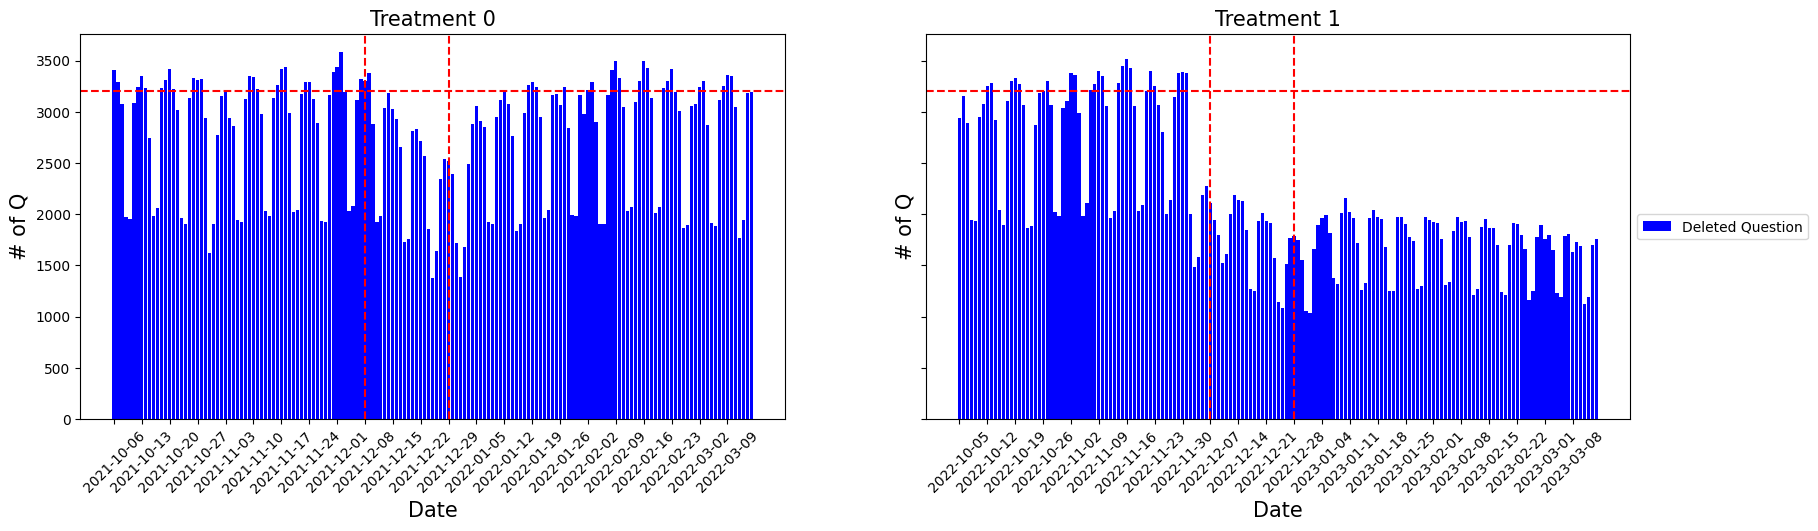

In [40]:
sharey = True ## 또는 sharey=False
sharex = True ## 또는 sharex=False

fig, axs = plt.subplots(1, 2, figsize = (20, 5), sharey=sharey, sharex=False)
# plt.xticks(rotation=45)
# yticks = np.arange(200, 2000, 400)

major_xticks = ['2021-10-06','2014-11-30','2015-11-30','2016-11-30','2017-11-30','2018-11-30','2019-11-30','2020-11-30'
                ,'2021-11-30', '2022-11-30', '2023-11-30']


axs[0].bar(treat0['date_mod'], treat0['q_d_cnt'], color='blue', label = 'Deleted Question')
axs[0].set_xticks(treat0_list)

axs[0].set_title('Treatment 0', fontsize = 15)
axs[0].set_xlabel('Date', fontsize = 15)
axs[0].set_ylabel('# of Q', fontsize = 15)
axs[0].set_xticks(treat0_list)
# axs[0].set_yticks(yticks)
axs[0].axvline([treat0_list[9]], # add vertical line
           color = 'red',
           linestyle = '--',
           linewidth = 1.5)

axs[0].axvline([treat0_list[12]], # add vertical line
           color = 'red',
           linestyle = '--',
           linewidth = 1.5)

axs[0].axhline(3200, # add vertical line
           color = 'red',
           linestyle = '--',
           linewidth = 1.5)

axs[0].tick_params(axis='x', rotation=45)
# axs[0].yticks(yt)

axs[1].bar(treat1['date_mod'], treat1['q_d_cnt'], color='blue', label = 'Deleted Question')

axs[1].set_title('Treatment 1', fontsize = 15)
axs[1].set_xlabel('Date', fontsize = 15)
axs[1].set_ylabel('# of Q', fontsize = 15)
axs[1].set_xticks(treat1_list)
# axs[1].set_yticks(yticks)
axs[1].axvline([treat1_list[9]], # add vertical line
           color = 'red',
           linestyle = '--',
           linewidth = 1.5)

axs[1].axvline([treat1_list[12]], # add vertical line
           color = 'red',
           linestyle = '--',
           linewidth = 1.5)

axs[1].axhline(3200, # add vertical line
           color = 'red',
           linestyle = '--',
           linewidth = 1.5)
axs[1].tick_params(axis='x', rotation=45)


axs[1].legend( title_fontsize = 10, fontsize = 10,
          bbox_to_anchor = (1, 0.55))

plt.show();


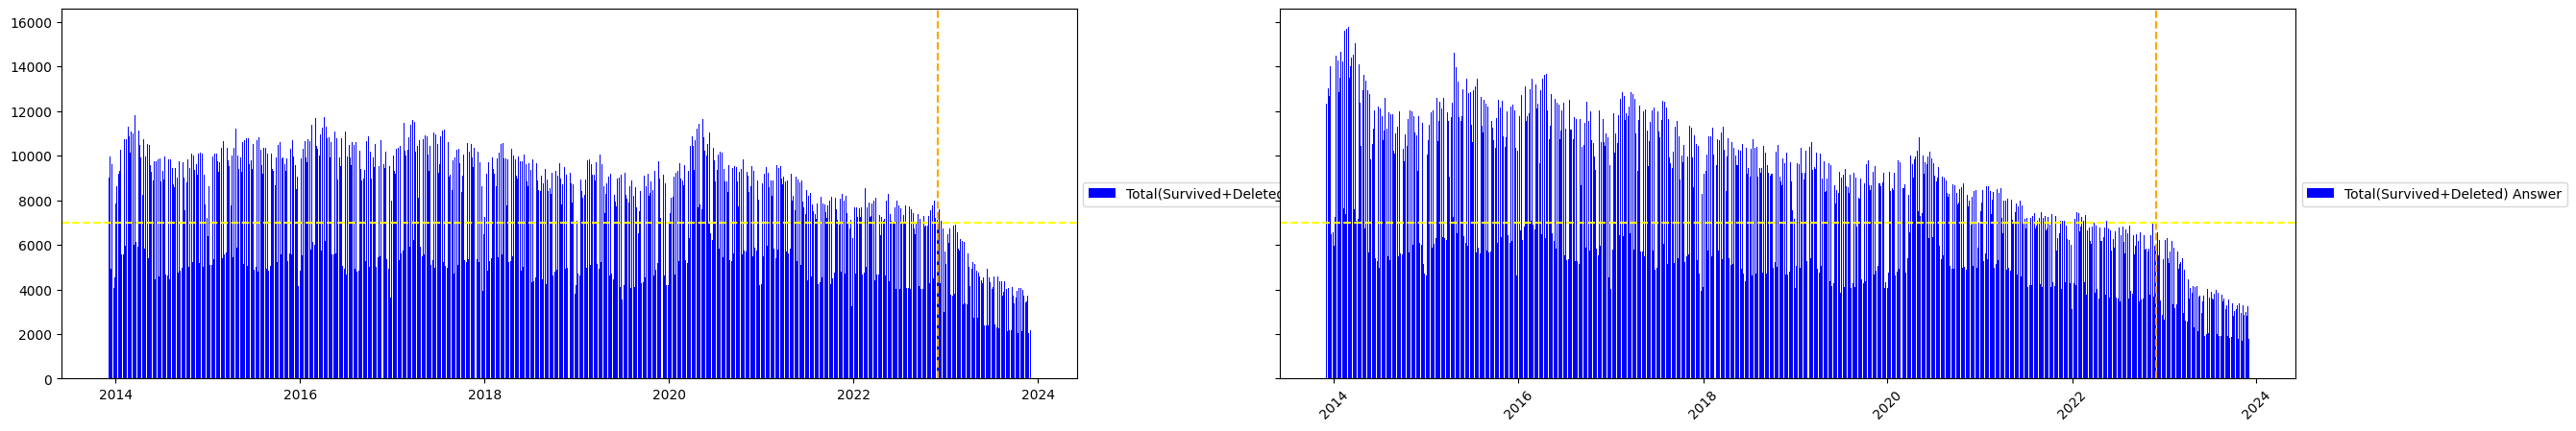

In [41]:
fig, ax = plt.subplots(1, 2, figsize = (30, 5), sharey=True, sharex=True)

# ax.bar(topic_per_pivot['date'], topic_per_pivot[0], width = 0.5, color='blue', label = 'Party A')
ax[0].bar(postwithdeleted_pivot['date_mod'], postwithdeleted_pivot['q_cnt'] + postwithdeleted_pivot['q_d_cnt'], color='blue', label = 'Total(Survived+Deleted) Question')

ax[0].axvline([major_xticks[-2]], # add vertical line
           color = 'orange',
           linestyle = '--',
           linewidth = 1.5)

ax[0].axhline(7000, # add vertical line
           color = 'yellow',
           linestyle = '--',
           linewidth = 1.5)

ax[0].legend( title_fontsize = 10, fontsize = 10,
          bbox_to_anchor = (1, 0.55))


ax[1].bar(postwithdeleted_pivot['date_mod'], postwithdeleted_pivot['a_cnt'] + postwithdeleted_pivot['a_d_cnt'], color='blue', label = 'Total(Survived+Deleted) Answer')


ax[1].axvline([major_xticks[-2]], # add vertical line
           color = 'orange',
           linestyle = '--',
           linewidth = 1.5)

ax[1].axhline(7000, # add vertical line
           color = 'yellow',
           linestyle = '--',
           linewidth = 1.5)

ax[1].legend( title_fontsize = 10, fontsize = 10,
          bbox_to_anchor = (1, 0.55))

plt.xticks(rotation = 45)
plt.show();
plt.show();

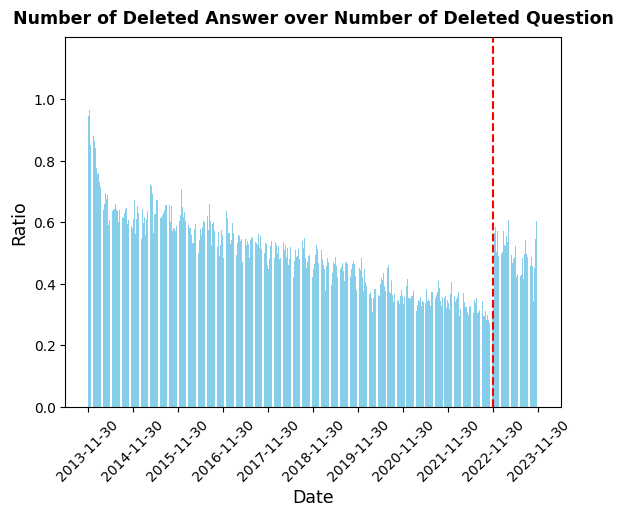

In [42]:
fig, ax = plt.subplots()


ax.bar(postwithdeleted_pivot.date_mod
    ,  height = postwithdeleted_pivot['ad_over_qd']
    ,  color = 'skyblue'
    ,  label = 'Mean'
    # ,  edgecolor = 'black'
      ) # hist type

ax.set_title("Number of Deleted Answer over Number of Deleted Question", # add title
             fontsize = 12.5,
             weight = 'bold',
             pad = 10,
             loc = 'center')
ax.set_xlabel("Date", # add x-axis label
              fontsize = 12.5)
ax.set_ylabel("Ratio", # add y-axis label
              fontsize = 12.5)

major_xticks = ['2013-11-30','2014-11-30','2015-11-30','2016-11-30','2017-11-30','2018-11-30','2019-11-30','2020-11-30'
                ,'2021-11-30', '2022-11-30', '2023-11-30']
ax.set_xticks(major_xticks)

ax.axvline(['2022-11-30'], # add vertical line
           color = 'red',
           linestyle = '--',
           linewidth = 1.5)
plt.xticks(rotation=45)
plt.show();

In [43]:
postwithdeleted_pivot['atot_over_qtot'] = postwithdeleted_pivot['tot_a_cnt']/ postwithdeleted_pivot['tot_q_cnt']

In [44]:
postwithdeleted_pivot['Date_num'] = np.arange(len(postwithdeleted_pivot.date_mod))

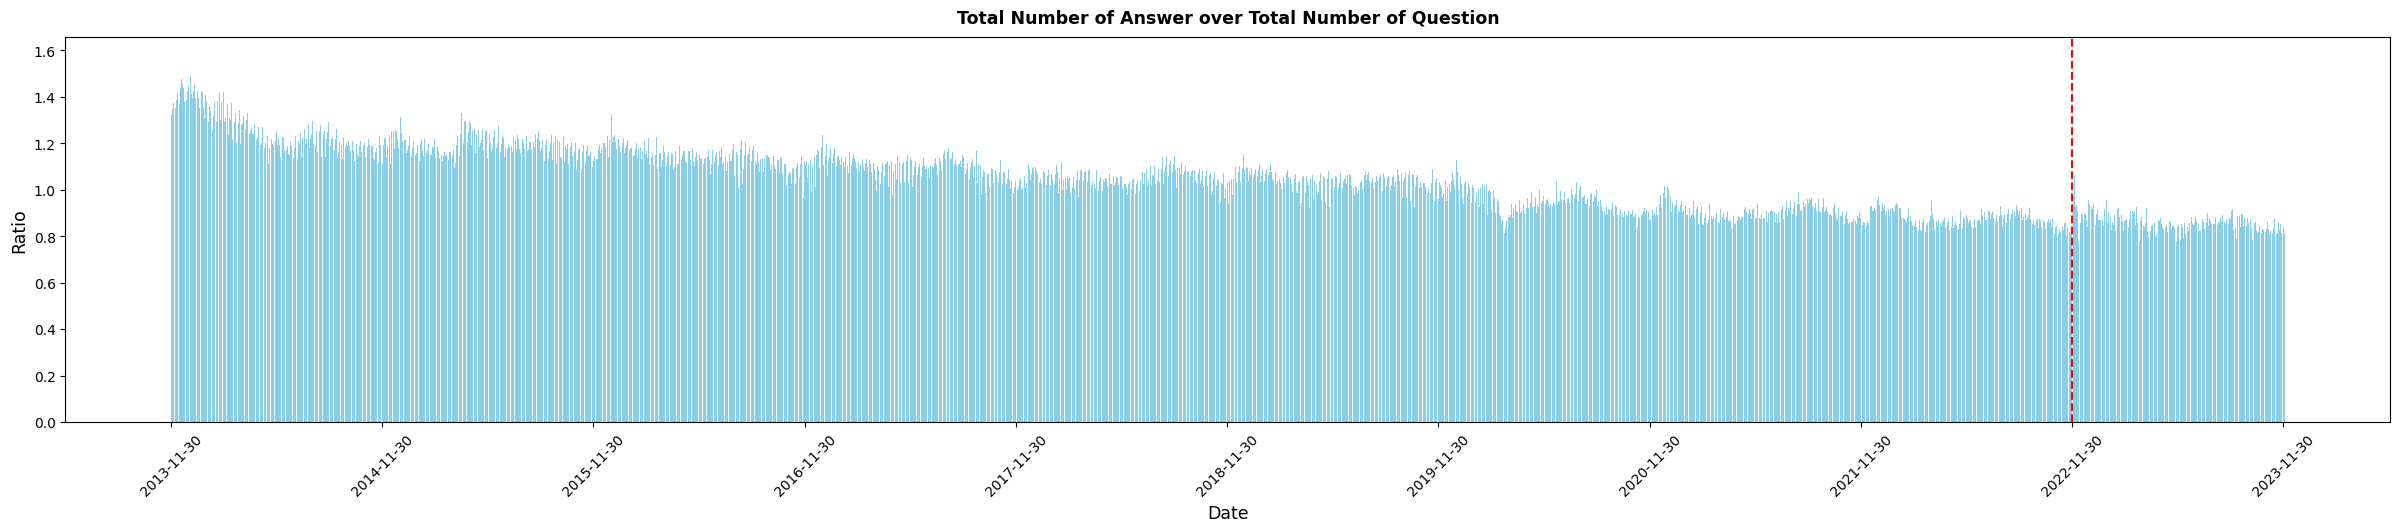

In [45]:
fig, ax = plt.subplots(figsize = (30, 5))


ax.bar(postwithdeleted_pivot.date_mod
    ,  height = postwithdeleted_pivot['atot_over_qtot']
    ,  color = 'skyblue'
    ,  label = 'Mean'
    # ,  edgecolor = 'black'
      ) # hist type

ax.set_title("Total Number of Answer over Total Number of Question", # add title
             fontsize = 12.5,
             weight = 'bold',
             pad = 10,
             loc = 'center')
ax.set_xlabel("Date", # add x-axis label
              fontsize = 12.5)
ax.set_ylabel("Ratio", # add y-axis label
              fontsize = 12.5)

major_xticks = ['2013-11-30','2014-11-30','2015-11-30','2016-11-30','2017-11-30','2018-11-30','2019-11-30','2020-11-30'
                ,'2021-11-30', '2022-11-30', '2023-11-30']
ax.set_xticks(major_xticks)

ax.axvline(['2022-11-30'], # add vertical line
           color = 'red',
           linestyle = '--',
           linewidth = 1.5)
plt.xticks(rotation=45)
plt.show();

In [46]:
postwithdeleted_pivot[postwithdeleted_pivot['date_mod']>= '2022-11-30'].head(20)

,date_mod,q_cnt,q_d_cnt,a_cnt,a_d_cnt,tot_d_cnt,tot_qna_cnt,tot_q_cnt,tot_a_cnt,ad_over_qd,atot_over_qtot,Date_num
5235,2022-11-30,4190.0,3387.0,5331.0,1038.0,4425.0,9521.0,7577.0,6369.0,0.306466,0.840570,3287
5236,2022-12-01,4285.0,3378.0,5153.0,1141.0,4519.0,9438.0,7663.0,6294.0,0.337774,0.821349,3288
5237,2022-12-02,4759.0,1998.0,5026.0,1542.0,3540.0,9785.0,6757.0,6568.0,0.771772,0.972029,3289
5238,2022-12-03,2935.0,1485.0,2989.0,1609.0,3094.0,5924.0,4420.0,4598.0,1.083502,1.040271,3290
5239,2022-12-04,2913.0,1584.0,2950.0,1810.0,3394.0,5863.0,4497.0,4760.0,1.142677,1.058483,3291
5240,2022-12-05,4957.0,2191.0,4816.0,1742.0,3933.0,9773.0,7148.0,6558.0,0.795071,0.917459,3292
5241,2022-12-06,5299.0,2280.0,5240.0,1770.0,4050.0,10539.0,7579.0,7010.0,0.776316,0.924924,3293
5242,2022-12-07,5001.0,2111.0,5138.0,1509.0,3620.0,10139.0,7112.0,6647.0,0.714827,0.934618,3294
5243,2022-12-08,4868.0,1947.0,5030.0,1488.0,3435.0,9898.0,6815.0,6518.0,0.764253,0.956420,3295
5244,2022-12-09,4261.0,1800.0,4499.0,1018.0,2818.0,8760.0,6061.0,5517.0,0.565556,0.910246,3296


In [47]:
postwithdeleted_pertype['mod_date'] = pd.to_datetime(postwithdeleted_pertype['cdate'])

In [48]:
delete_pertype = postwithdeleted_pertype[~(postwithdeleted_pertype['dreason'] =='Ali')]

In [49]:
delete_pertype[['dreason', 'posttypeid']].drop_duplicates()

,dreason,posttypeid
0,Que,2
6,Ans,2
7,Que,1


In [50]:
delete_pertype = delete_pertype.sort_values(by = ['mod_date']).reset_index(drop=True)

In [51]:
delete_pertype = delete_pertype[delete_pertype['mod_date'] >= '2013-11-30']

In [52]:
cond1 = (delete_pertype['posttypeid'] == 1)
cond2 = (delete_pertype['posttypeid'] == 2)
cond3 = (delete_pertype['dreason'] == 'Ans')
cond4 = (delete_pertype['dreason'] == 'Que')


# 1 Que > cond1&cond4 
# 2 Que > cond2&cond4
# 2 Ans > cond2&cond3


In [53]:
delete_pertype.loc[cond2&cond3, 'mod_date'] >= '2013-11-30'

5844     True
5848     True
5850     True
5853     True
5858     True
         ... 
16796    True
16799    True
16800    True
16805    True
16807    True
Name: mod_date, Length: 3655, dtype: bool

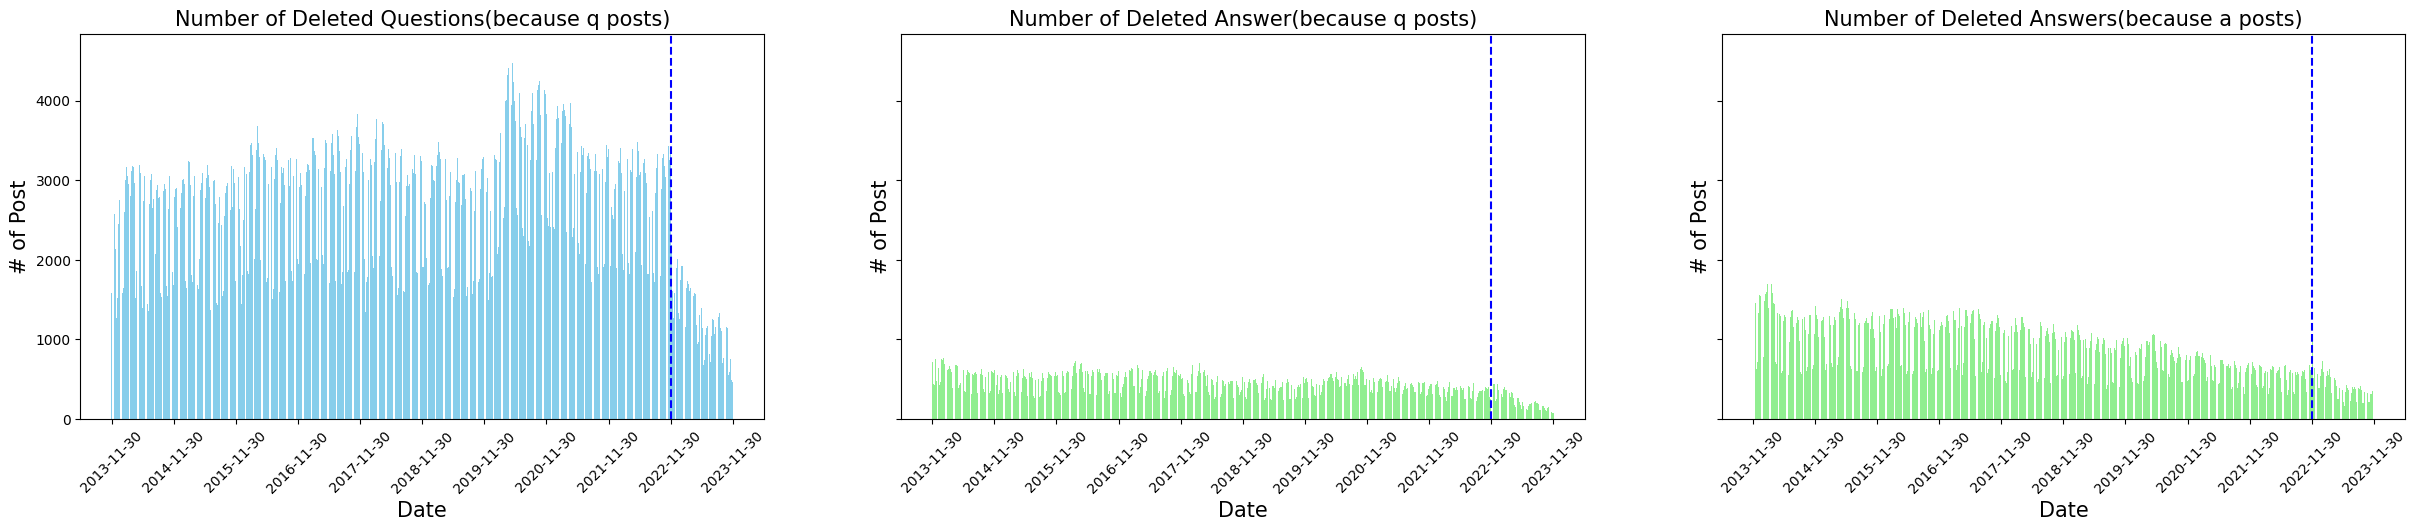

In [54]:
sharey = True ## 또는 sharey=False
sharex = True ## 또는 sharex=False

fig, axs = plt.subplots(1, 3, figsize = (30, 5), sharey=sharey, sharex=sharex)
# plt.xticks(rotation=45)
major_xticks = ['2013-11-30','2014-11-30','2015-11-30','2016-11-30','2017-11-30','2018-11-30','2019-11-30','2020-11-30'
                ,'2021-11-30', '2022-11-30', '2023-11-30']
# yticks = np.arange(200, 2000, 400)
axs[0].bar(delete_pertype[cond1&cond4 ].mod_date
        ,  height = delete_pertype[cond1&cond4 ].cnt
        ,  color = 'skyblue'
        # ,  edgecolor = 'black'
      ) # hist type

axs[0].set_title('Number of Deleted Questions(because q posts)', fontsize = 15)
axs[0].set_xlabel('Date', fontsize = 15)
axs[0].set_ylabel('# of Post', fontsize = 15)
axs[0].set_xticks(major_xticks)
# axs[0].set_yticks(yticks)
axs[0].axvline([major_xticks[-2]], # add vertical line
           color = 'blue',
           linestyle = '--',
           linewidth = 1.5)
axs[0].tick_params(axis='x', rotation=45)
# axs[0].yticks(yt)

axs[1].bar(delete_pertype[cond2&cond4].mod_date
        ,  height = delete_pertype[cond2&cond4].cnt
        ,  color = 'lightgreen'
        # ,  edgecolor = 'black'
      ) # hist type

axs[1].set_title('Number of Deleted Answer(because q posts)', fontsize = 15)
axs[1].set_xlabel('Date', fontsize = 15)
axs[1].set_ylabel('# of Post', fontsize = 15)
axs[1].set_xticks(major_xticks)
# axs[1].set_yticks(yticks)
axs[1].axvline([major_xticks[-2]], # add vertical line
           color = 'blue',
           linestyle = '--',
           linewidth = 1.5)
axs[1].tick_params(axis='x', rotation=45)

axs[2].bar(delete_pertype[cond2&cond3].mod_date
        ,  height = delete_pertype[cond2&cond3].cnt
        ,  color = 'lightgreen'
        # ,  edgecolor = 'black'
      ) # hist type

axs[2].set_title('Number of Deleted Answers(because a posts)', fontsize = 15)
axs[2].set_xlabel('Date', fontsize = 15)
axs[2].set_ylabel('# of Post', fontsize = 15)
axs[2].set_xticks(major_xticks)
# axs[1].set_yticks(yticks)
axs[2].axvline([major_xticks[-2]], # add vertical line
           color = 'blue',
           linestyle = '--',
           linewidth = 1.5)
axs[2].tick_params(axis='x', rotation=45)



plt.show();


In [55]:

# 1 Que > cond1&cond4 
# 2 Que > cond2&cond4
# 2 Ans > cond2&cond3


delete_pertype['posttypeid'] = delete_pertype['posttypeid'].astype(str)

In [56]:

delete_pertype['type_r'] = delete_pertype['posttypeid'] +delete_pertype['dreason']

In [57]:
delete_pertype_pivot = delete_pertype.pivot_table(index = 'mod_date', columns  = 'type_r', values='cnt').reset_index()
# ['type_r']

In [58]:
delete_pertype_pivot

type_r,mod_date,1Que,2Ans,2Que
0,2013-11-30,1582.0,756.0,436.0
1,2013-12-01,1529.0,640.0,449.0
2,2013-12-02,2544.0,1276.0,716.0
3,2013-12-03,2794.0,1446.0,862.0
4,2013-12-04,2812.0,1547.0,760.0
...,...,...,...,...
3650,2023-11-28,510.0,342.0,106.0
3651,2023-11-29,463.0,333.0,88.0
3652,2023-11-30,424.0,300.0,85.0
3653,2023-12-01,388.0,224.0,71.0


In [59]:
delete_pertype_pivot['tot_sum'] = delete_pertype_pivot[['1Que', '2Ans', '2Que']].sum(axis = 1)

In [60]:
delete_pertype_pivot['1Que_r'] = delete_pertype_pivot['1Que']/delete_pertype_pivot['tot_sum']*100
delete_pertype_pivot['2Que_r'] = delete_pertype_pivot['2Que']/delete_pertype_pivot['tot_sum']*100
delete_pertype_pivot['2Ans_r'] = delete_pertype_pivot['2Ans']/delete_pertype_pivot['tot_sum']*100

In [61]:
delete_pertype_pivot

type_r,mod_date,1Que,2Ans,2Que,tot_sum,1Que_r,2Que_r,2Ans_r
0,2013-11-30,1582.0,756.0,436.0,2774.0,57.029560,15.717376,27.253064
1,2013-12-01,1529.0,640.0,449.0,2618.0,58.403361,17.150497,24.446142
2,2013-12-02,2544.0,1276.0,716.0,4536.0,56.084656,15.784832,28.130511
3,2013-12-03,2794.0,1446.0,862.0,5102.0,54.762838,16.895335,28.341827
4,2013-12-04,2812.0,1547.0,760.0,5119.0,54.932604,14.846650,30.220746
...,...,...,...,...,...,...,...,...
3650,2023-11-28,510.0,342.0,106.0,958.0,53.235908,11.064718,35.699374
3651,2023-11-29,463.0,333.0,88.0,884.0,52.375566,9.954751,37.669683
3652,2023-11-30,424.0,300.0,85.0,809.0,52.410383,10.506799,37.082818
3653,2023-12-01,388.0,224.0,71.0,683.0,56.808199,10.395315,32.796486


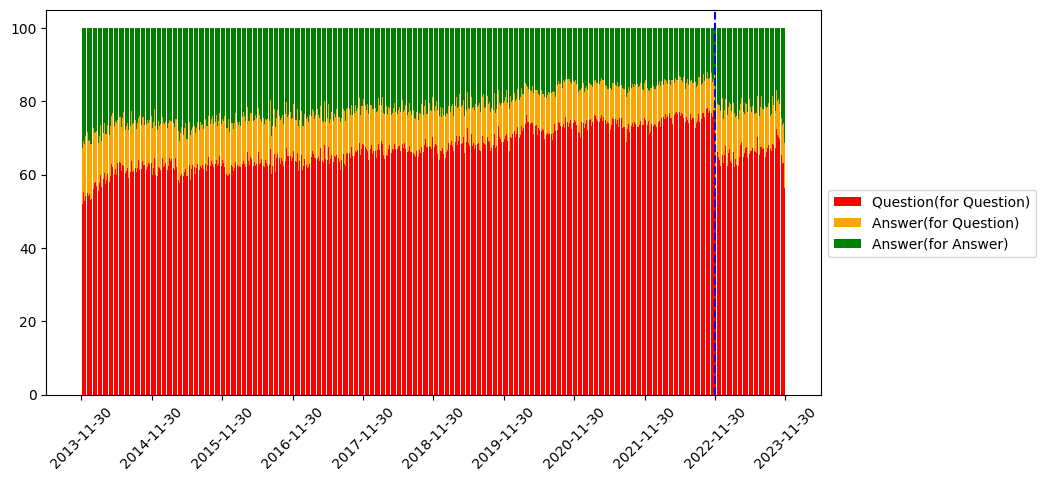

In [62]:
### Problem 2b: Reformat the data and generate the stacked bar plot above.


fig, ax = plt.subplots(figsize = (10, 5))

# ax.bar(topic_per_pivot['date'], topic_per_pivot[0], width = 0.5, color='blue', label = 'Party A')
ax.bar(delete_pertype_pivot['mod_date'], delete_pertype_pivot['1Que_r'], color='red', label = 'Question(for Question)')
ax.bar(delete_pertype_pivot['mod_date'], delete_pertype_pivot['2Que_r'], bottom = delete_pertype_pivot['1Que_r'], color = 'orange', label = 'Answer(for Question)')
ax.bar(delete_pertype_pivot['mod_date'], delete_pertype_pivot['2Ans_r'], bottom = delete_pertype_pivot['2Que_r'] + delete_pertype_pivot['1Que_r'], color = 'green', label = 'Answer(for Answer)')

ax.axvline([major_xticks[-2]], # add vertical line
           color = 'blue',
           linestyle = '--',
           linewidth = 1.5)

ax.legend( title_fontsize = 10, fontsize = 10,
          bbox_to_anchor = (1, 0.55))


major_xticks = ['2013-11-30','2014-11-30','2015-11-30','2016-11-30','2017-11-30','2018-11-30','2019-11-30','2020-11-30'
                ,'2021-11-30', '2022-11-30', '2023-11-30']
ax.set_xticks(major_xticks)
ax.tick_params(axis='x', rotation=45)


plt.xticks(rotation = 45)
plt.show();

In [63]:
deletedwithin['date_mod'] = pd.to_datetime(deletedwithin['cdate'])
totdeletedwithin['date_mod'] = pd.to_datetime(totdeletedwithin['cdate'])

In [64]:
totdeletedwithin.head()

,cdate,posttypeid,totpostcnt,deletedpostcnt,deletedwithinamonth,deletedwithinaweek,date_mod
0,2012-04-13 00:00:00,2,10331,1582,1053,1018,2012-04-13
1,2013-10-03 00:00:00,1,9309,2469,1273,731,2013-10-03
2,2012-07-09 00:00:00,1,6663,1475,426,371,2012-07-09
3,2011-01-18 00:00:00,2,7406,1178,585,549,2011-01-18
4,2015-12-27 00:00:00,2,5293,864,729,635,2015-12-27


In [65]:
deletedwithin['deletedwithinamonth_r'] = deletedwithin['deletedwithinamonth']/deletedwithin['deletedpostcnt']*100
deletedwithin['deletedwithinaweek_r'] = deletedwithin['deletedwithinaweek']/deletedwithin['deletedpostcnt']*100

In [66]:
totdeletedwithin['deletedwithinamonth_over_tot_r'] = totdeletedwithin['deletedwithinamonth']/totdeletedwithin['totpostcnt']*100
totdeletedwithin['deletedwithinaweek_over_tot_r'] = totdeletedwithin['deletedwithinaweek']/totdeletedwithin['totpostcnt']*100

In [67]:
totdeletedwithin.head()

,cdate,posttypeid,totpostcnt,deletedpostcnt,deletedwithinamonth,deletedwithinaweek,date_mod,deletedwithinamonth_over_tot_r,deletedwithinaweek_over_tot_r
0,2012-04-13 00:00:00,2,10331,1582,1053,1018,2012-04-13,10.192624,9.853838
1,2013-10-03 00:00:00,1,9309,2469,1273,731,2013-10-03,13.674938,7.852616
2,2012-07-09 00:00:00,1,6663,1475,426,371,2012-07-09,6.393516,5.568062
3,2011-01-18 00:00:00,2,7406,1178,585,549,2011-01-18,7.899001,7.412908
4,2015-12-27 00:00:00,2,5293,864,729,635,2015-12-27,13.772908,11.996977


In [68]:
deletedwithin.sort_values(by = ['date_mod'], inplace = True)
totdeletedwithin.sort_values(by = ['date_mod'], inplace = True)

In [69]:
deletedwithin = deletedwithin[deletedwithin['date_mod']>='2013-11-30']
totdeletedwithin = totdeletedwithin[totdeletedwithin['date_mod']>='2013-11-30']

In [70]:
deletedwithin_pivot = deletedwithin.pivot_table(index='date_mod', columns = ['posttypeid'], values = ['deletedwithinamonth_r', 'deletedwithinaweek_r'])
totdeletedwithin_pivot = totdeletedwithin.pivot_table(index='date_mod', columns = ['posttypeid'], values = ['deletedwithinamonth_over_tot_r', 'deletedwithinaweek_over_tot_r'])

In [71]:
deletedwithin_pivot.index

DatetimeIndex(['2013-11-30', '2013-12-01', '2013-12-02', '2013-12-03',
               '2013-12-04', '2013-12-05', '2013-12-06', '2013-12-07',
               '2013-12-08', '2013-12-09',
               ...
               '2023-11-23', '2023-11-24', '2023-11-25', '2023-11-26',
               '2023-11-27', '2023-11-28', '2023-11-29', '2023-11-30',
               '2023-12-01', '2023-12-02'],
              dtype='datetime64[ns]', name='date_mod', length=3655, freq=None)

In [72]:
deletedwithin_pivot['deletedwithinamonth_r',1]  

date_mod
2013-11-30    74.588665
2013-12-01    75.704568
2013-12-02    73.968447
2013-12-03    75.313569
2013-12-04    75.013912
                ...    
2023-11-28    73.946958
2023-11-29    73.761170
2023-11-30    75.728155
2023-12-01    76.923077
2023-12-02    77.356322
Name: (deletedwithinamonth_r, 1), Length: 3655, dtype: float64

In [73]:
deletedwithin

,cdate,posttypeid,deletedpostcnt,deletedwithinamonth,deletedwithinaweek,date_mod,deletedwithinamonth_r,deletedwithinaweek_r
1077,2013-11-30 00:00:00,2,1053,931,801,2013-11-30,88.414055,76.068376
4188,2013-11-30 00:00:00,1,1094,816,487,2013-11-30,74.588665,44.515539
3712,2013-12-01 00:00:00,2,940,822,698,2013-12-01,87.446809,74.255319
9205,2013-12-01 00:00:00,1,1029,779,451,2013-12-01,75.704568,43.828960
4961,2013-12-02 00:00:00,1,1648,1219,718,2013-12-02,73.968447,43.567961
...,...,...,...,...,...,...,...,...
10804,2023-11-30 00:00:00,1,1236,936,501,2023-11-30,75.728155,40.533981
6867,2023-12-01 00:00:00,2,506,444,364,2023-12-01,87.747036,71.936759
783,2023-12-01 00:00:00,1,1131,870,486,2023-12-01,76.923077,42.970822
4343,2023-12-02 00:00:00,1,870,673,373,2023-12-02,77.356322,42.873563


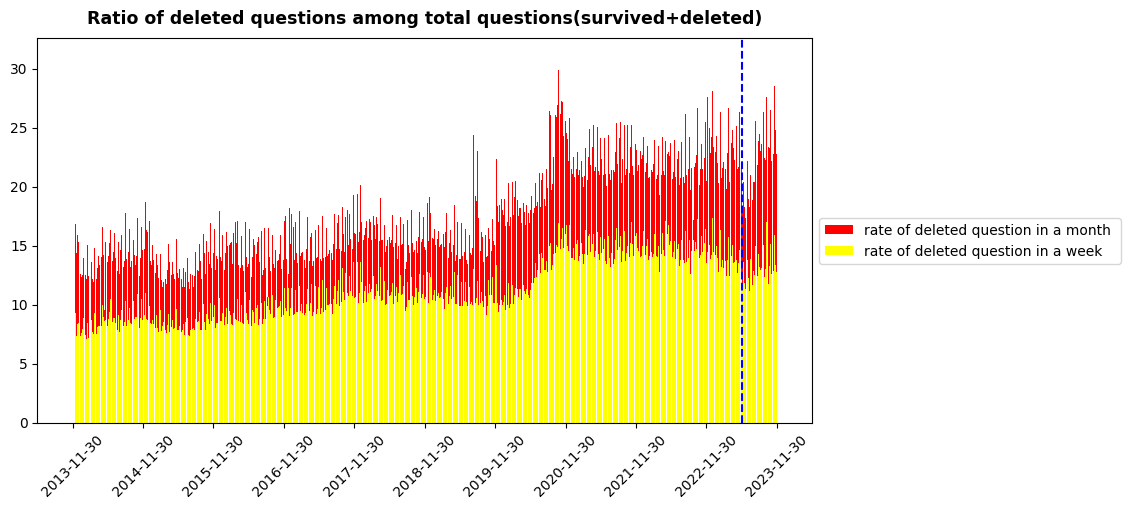

In [74]:
### Problem 2b: Reformat the data and generate the stacked bar plot above.


fig, ax = plt.subplots(figsize = (10, 5))

# ax.bar(topic_per_pivot['date'], topic_per_pivot[0], width = 0.5, color='blue', label = 'Party A')
ax.bar(totdeletedwithin_pivot.index, totdeletedwithin_pivot['deletedwithinamonth_over_tot_r',1]  , color='red', label =  'rate of deleted question in a month ')
ax.bar(totdeletedwithin_pivot.index, totdeletedwithin_pivot['deletedwithinaweek_over_tot_r',1]  , color='yellow', label = 'rate of deleted question in a week')

ax.axvline(['2023-06-01'], # add vertical line
           color = 'blue',
           linestyle = '--',
           linewidth = 1.5)

ax.legend( title_fontsize = 10, fontsize = 10,
          bbox_to_anchor = (1, 0.55))

ax.set_title("Ratio of deleted questions among total questions(survived+deleted)", # add title
             fontsize = 12.5,
             weight = 'bold',
             pad = 10,
             loc = 'center')

major_xticks = ['2013-11-30','2014-11-30','2015-11-30','2016-11-30','2017-11-30','2018-11-30','2019-11-30','2020-11-30'
                ,'2021-11-30', '2022-11-30', '2023-11-30']
ax.set_xticks(major_xticks)

plt.xticks(rotation = 45)
plt.show();

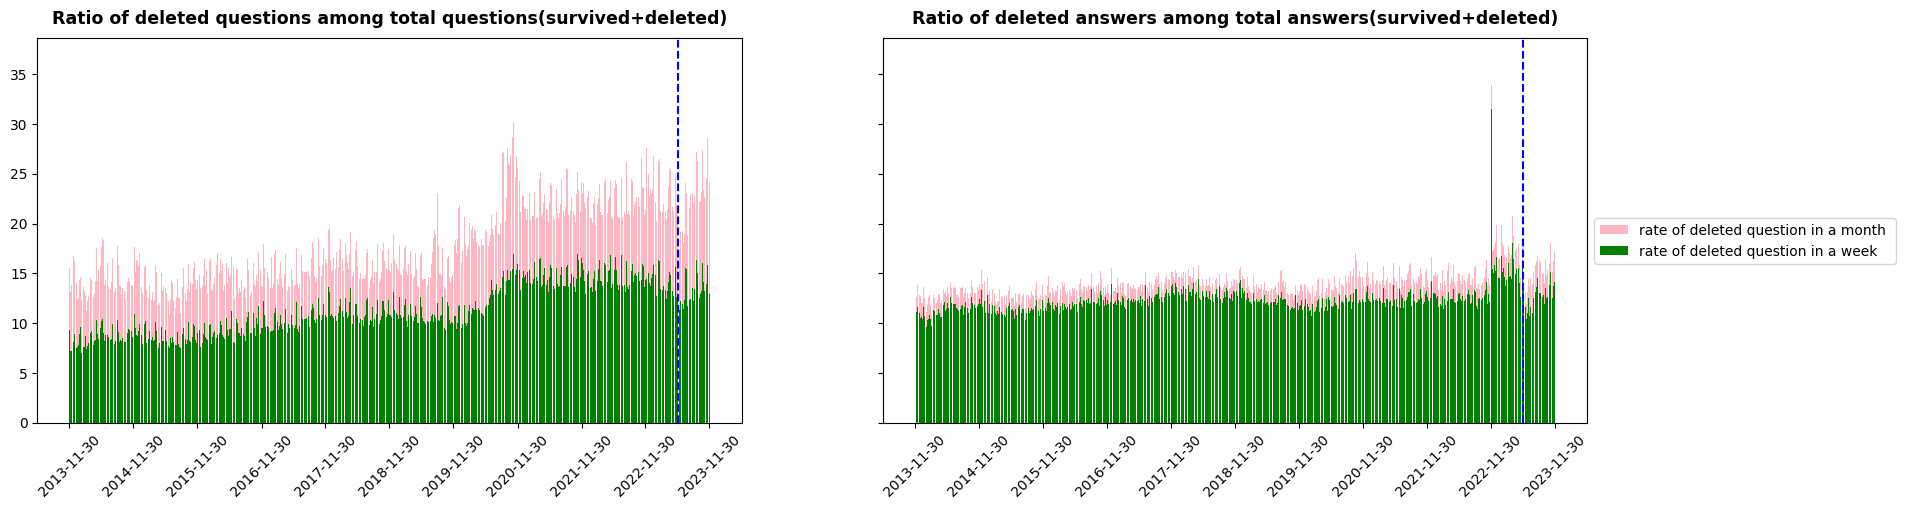

In [75]:
### Problem 2b: Reformat the data and generate the stacked bar plot above.


fig, axs = plt.subplots(1, 2, figsize = (20, 5), sharey=sharey, sharex=sharex)

# ax.bar(topic_per_pivot['date'], topic_per_pivot[0], width = 0.5, color='blue', label = 'Party A')
axs[0].bar(totdeletedwithin_pivot.index, totdeletedwithin_pivot['deletedwithinamonth_over_tot_r',1]  , color='lightpink', label =  'rate of deleted question in a month ')
axs[0].bar(totdeletedwithin_pivot.index, totdeletedwithin_pivot['deletedwithinaweek_over_tot_r',1]  , color='green', label = 'rate of deleted question in a week')

axs[0].axvline(['2023-06-01'], # add vertical line
           color = 'blue',
           linestyle = '--',
           linewidth = 1.5)
axs[0].set_title("Ratio of deleted questions among total questions(survived+deleted)", # add title
             fontsize = 12.5,
             weight = 'bold',
             pad = 10,
             loc = 'center')

major_xticks = ['2013-11-30','2014-11-30','2015-11-30','2016-11-30','2017-11-30','2018-11-30','2019-11-30','2020-11-30'
                ,'2021-11-30', '2022-11-30', '2023-11-30']
axs[0].set_xticks(major_xticks)
axs[0].tick_params(axis='x', rotation=45)



# ax.bar(topic_per_pivot['date'], topic_per_pivot[0], width = 0.5, color='blue', label = 'Party A')
axs[1].bar(totdeletedwithin_pivot.index, totdeletedwithin_pivot['deletedwithinamonth_over_tot_r',2]  , color='lightpink', label =  'rate of deleted question in a month ')
axs[1].bar(totdeletedwithin_pivot.index, totdeletedwithin_pivot['deletedwithinaweek_over_tot_r',2]  , color='green', label = 'rate of deleted question in a week')

axs[1].axvline(['2023-06-01'], # add vertical line
           color = 'blue',
           linestyle = '--',
           linewidth = 1.5)

axs[1].set_title("Ratio of deleted answers among total answers(survived+deleted)", # add title
             fontsize = 12.5,
             weight = 'bold',
             pad = 10,
             loc = 'center')


major_xticks = ['2013-11-30','2014-11-30','2015-11-30','2016-11-30','2017-11-30','2018-11-30','2019-11-30','2020-11-30'
                ,'2021-11-30', '2022-11-30', '2023-11-30']
axs[1].set_xticks(major_xticks)
axs[1].tick_params(axis='x', rotation=45)


axs[1].legend( title_fontsize = 10, fontsize = 10,
          bbox_to_anchor = (1, 0.55))



plt.show();

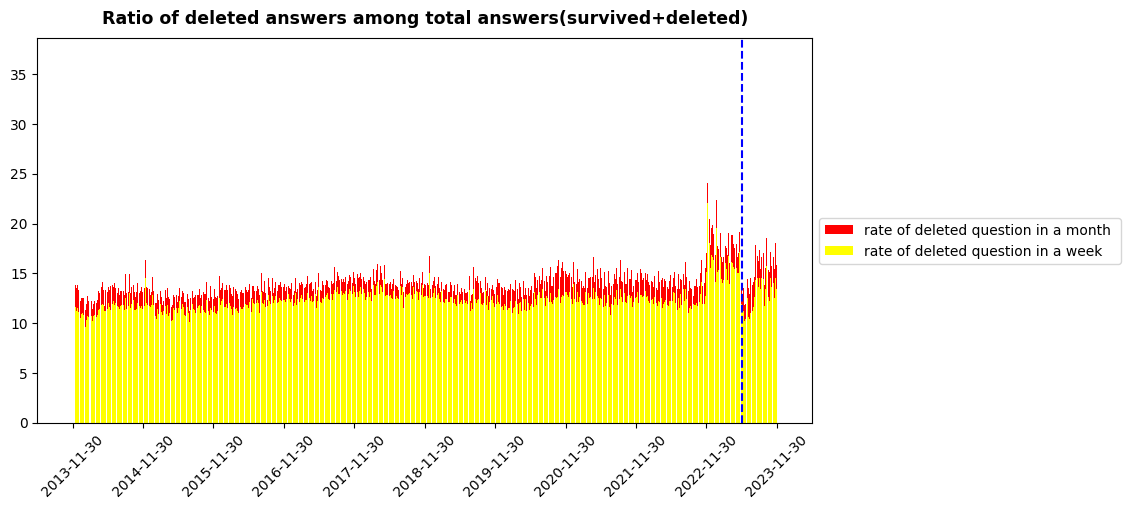

In [76]:
### Problem 2b: Reformat the data and generate the stacked bar plot above.


fig, ax = plt.subplots(figsize = (10, 5))

# ax.bar(topic_per_pivot['date'], topic_per_pivot[0], width = 0.5, color='blue', label = 'Party A')
ax.bar(totdeletedwithin_pivot.index, totdeletedwithin_pivot['deletedwithinamonth_over_tot_r',2]  , color='red', label =  'rate of deleted question in a month ')
ax.bar(totdeletedwithin_pivot.index, totdeletedwithin_pivot['deletedwithinaweek_over_tot_r',2]  , color='yellow', label = 'rate of deleted question in a week')

ax.axvline([['2023-06-01']], # add vertical line
           color = 'blue',
           linestyle = '--',
           linewidth = 1.5)

ax.legend( title_fontsize = 10, fontsize = 10,
          bbox_to_anchor = (1, 0.55))

ax.set_title("Ratio of deleted answers among total answers(survived+deleted)", # add title
             fontsize = 12.5,
             weight = 'bold',
             pad = 10,
             loc = 'center')


major_xticks = ['2013-11-30','2014-11-30','2015-11-30','2016-11-30','2017-11-30','2018-11-30','2019-11-30','2020-11-30'
                ,'2021-11-30', '2022-11-30', '2023-11-30']
ax.set_xticks(major_xticks)

plt.xticks(rotation = 45)
plt.show();

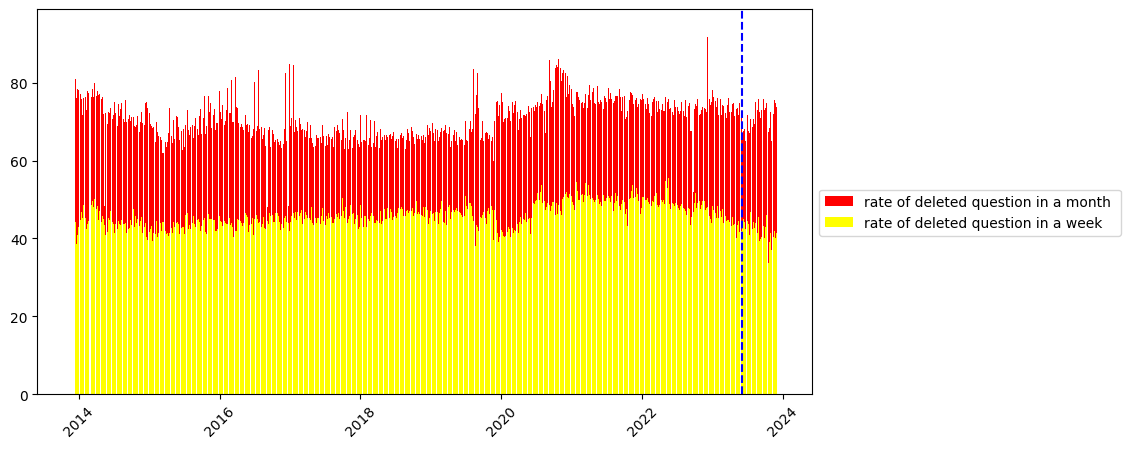

In [77]:
### Problem 2b: Reformat the data and generate the stacked bar plot above.


fig, ax = plt.subplots(figsize = (10, 5))

# ax.bar(topic_per_pivot['date'], topic_per_pivot[0], width = 0.5, color='blue', label = 'Party A')
ax.bar(deletedwithin_pivot.index, deletedwithin_pivot['deletedwithinamonth_r',1]  , color='red', label =  'rate of deleted question in a month ')
ax.bar(deletedwithin_pivot.index, deletedwithin_pivot['deletedwithinaweek_r',1]  , color='yellow', label = 'rate of deleted question in a week')

ax.axvline(['2023-06-01'], # add vertical line
           color = 'blue',
           linestyle = '--',
           linewidth = 1.5)

ax.legend( title_fontsize = 10, fontsize = 10,
          bbox_to_anchor = (1, 0.55))

plt.xticks(rotation = 45)
plt.show();

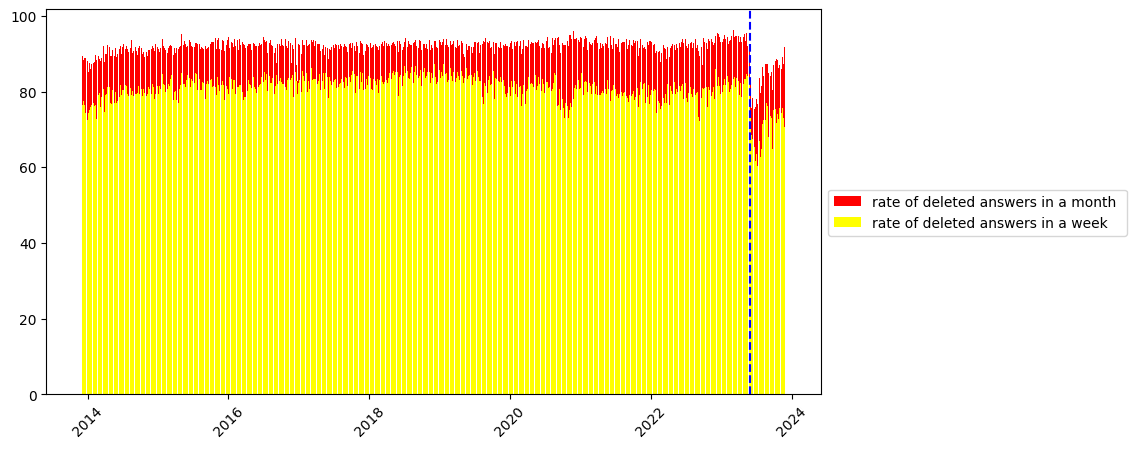

In [78]:
### Problem 2b: Reformat the data and generate the stacked bar plot above.


fig, ax = plt.subplots(figsize = (10, 5))

# ax.bar(topic_per_pivot['date'], topic_per_pivot[0], width = 0.5, color='blue', label = 'Party A')
ax.bar(deletedwithin_pivot.index, deletedwithin_pivot['deletedwithinamonth_r',2]  , color='red', label = 'rate of deleted answers in a month ')
ax.bar(deletedwithin_pivot.index, deletedwithin_pivot['deletedwithinaweek_r',2]  , color='yellow', label = 'rate of deleted answers in a week')

ax.axvline(['2023-06-01'], # add vertical line
           color = 'blue',
           linestyle = '--',
           linewidth = 1.5)

ax.legend( title_fontsize = 10, fontsize = 10,
          bbox_to_anchor = (1, 0.55))

plt.xticks(rotation = 45)
plt.show();

In [79]:
tmp = deletedwithin_pivot['deletedwithinaweek_r',2].to_frame().reset_index()

In [80]:
tmp.to_csv('./chk.csv')

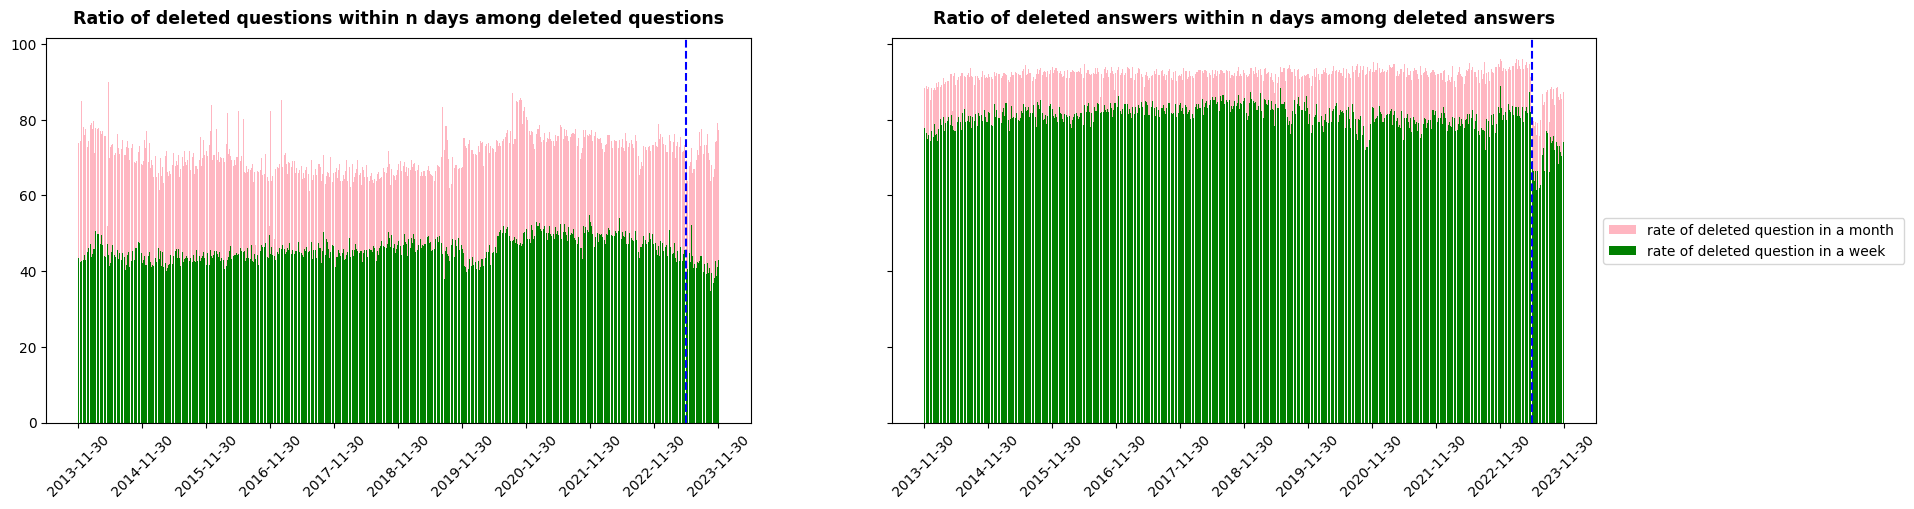

In [81]:
### Problem 2b: Reformat the data and generate the stacked bar plot above.


fig, axs = plt.subplots(1, 2, figsize = (20, 5), sharey=sharey, sharex=sharex)

# ax.bar(topic_per_pivot['date'], topic_per_pivot[0], width = 0.5, color='blue', label = 'Party A')
axs[0].bar(deletedwithin_pivot.index, deletedwithin_pivot['deletedwithinamonth_r',1]  , color='lightpink', label =  'rate of deleted question in a month ')
axs[0].bar(deletedwithin_pivot.index, deletedwithin_pivot['deletedwithinaweek_r',1]  , color='green', label = 'rate of deleted question in a week')

axs[0].axvline(['2023-06-01'], # add vertical line
           color = 'blue',
           linestyle = '--',
           linewidth = 1.5)
axs[0].set_title("Ratio of deleted questions within n days among deleted questions", # add title
             fontsize = 12.5,
             weight = 'bold',
             pad = 10,
             loc = 'center')

major_xticks = ['2013-11-30','2014-11-30','2015-11-30','2016-11-30','2017-11-30','2018-11-30','2019-11-30','2020-11-30'
                ,'2021-11-30', '2022-11-30', '2023-11-30']
axs[0].set_xticks(major_xticks)
axs[0].tick_params(axis='x', rotation=45)



# ax.bar(topic_per_pivot['date'], topic_per_pivot[0], width = 0.5, color='blue', label = 'Party A')
axs[1].bar(deletedwithin_pivot.index, deletedwithin_pivot['deletedwithinamonth_r',2]  , color='lightpink', label =  'rate of deleted question in a month ')
axs[1].bar(deletedwithin_pivot.index, deletedwithin_pivot['deletedwithinaweek_r',2]  , color='green', label = 'rate of deleted question in a week')

axs[1].axvline(['2023-06-01'], # add vertical line
           color = 'blue',
           linestyle = '--',
           linewidth = 1.5)

axs[1].set_title("Ratio of deleted answers within n days among deleted answers", # add title
             fontsize = 12.5,
             weight = 'bold',
             pad = 10,
             loc = 'center')


major_xticks = ['2013-11-30','2014-11-30','2015-11-30','2016-11-30','2017-11-30','2018-11-30','2019-11-30','2020-11-30'
                ,'2021-11-30', '2022-11-30', '2023-11-30']
axs[1].set_xticks(major_xticks)
axs[1].tick_params(axis='x', rotation=45)


axs[1].legend( title_fontsize = 10, fontsize = 10,
          bbox_to_anchor = (1, 0.55))




plt.show();

In [82]:
deletedATags.head()

,cdate,deletedwithinamonth,python,javascript,reactjs,java,c#,html,r,pandas,...,mongodb,vuejs,numpy,net,vba,regex,string,spring,powershell,linux
0,2022-11-30 00:00:00,0,2,4,0,0,0,3,0,1,...,1,0,0,0,0,0,0,0,1,2
1,2022-12-01 00:00:00,0,8,5,3,0,3,2,1,2,...,0,0,0,0,0,0,2,0,0,0
2,2022-12-02 00:00:00,0,7,10,5,4,1,2,0,1,...,0,0,0,0,0,1,1,1,0,0
3,2022-12-03 00:00:00,0,4,2,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2022-12-04 00:00:00,0,10,4,1,2,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


In [83]:
deletedQTags.head()

,cdate,deletedwithinamonth,python,javascript,reactjs,java,c#,html,r,pandas,...,mongodb,vuejs,numpy,net,vba,regex,string,spring,powershell,linux
0,2022-12-01 00:00:00,0,114,68,19,30,28,20,10,7,...,6,2,3,0,8,15,4,3,5,5
1,2022-12-04 00:00:00,0,97,59,28,28,9,33,6,6,...,0,5,1,0,0,7,7,3,0,8
2,2022-12-24 00:00:00,0,41,29,7,21,9,8,6,4,...,1,0,2,0,0,5,4,2,1,2
3,2022-12-27 00:00:00,0,87,62,27,23,5,25,2,8,...,0,3,0,0,1,4,2,3,0,2
4,2022-12-30 00:00:00,0,62,41,19,29,15,15,4,5,...,2,0,2,0,1,1,3,6,0,2


In [84]:
deletedATags = deletedATags.sort_values(by = ['cdate', 'deletedwithinamonth']).reset_index(drop=True)
deletedQTags = deletedQTags.sort_values(by = ['cdate', 'deletedwithinamonth']).reset_index(drop=True)

In [85]:
deletedATags['cdate'] = pd.to_datetime(deletedATags['cdate'])
deletedQTags['cdate'] = pd.to_datetime(deletedQTags['cdate'])

In [86]:
deletedATags_pivot = deletedATags.pivot_table(index = 'cdate', columns=['deletedwithinamonth'], values  = deletedATags.columns[2:])
deletedQTags_pivot = deletedQTags.pivot_table(index = 'cdate', columns=['deletedwithinamonth'], values  = deletedQTags.columns[2:])

In [87]:
deletedQTags_pivot['amazon_web_services']

deletedwithinamonth,0,1
cdate,,
2022-11-30,12.0,15.0
2022-12-01,5.0,17.0
2022-12-02,5.0,4.0
2022-12-03,1.0,5.0
2022-12-04,1.0,6.0
...,...,...
2023-11-25,1.0,8.0
2023-11-26,0.0,4.0
2023-11-27,8.0,11.0


In [88]:
deletedATags_pivot['amazon_web_services']

deletedwithinamonth,0,1
cdate,,
2022-11-30,0.0,6.0
2022-12-01,0.0,11.0
2022-12-02,0.0,10.0
2022-12-03,0.0,13.0
2022-12-04,1.0,8.0
...,...,...
2023-11-25,0.0,3.0
2023-11-26,1.0,1.0
2023-11-27,0.0,5.0


In [89]:
deletedATags_pivot.fillna(0, inplace=True)
deletedQTags_pivot.fillna(0, inplace=True)

In [90]:
deletedQTags_pivot.tail()

amazon_web_services       android       angular        \
deletedwithinamonth                   0     1       0     1       0     1   
cdate                                                                       
2023-11-25                          1.0   8.0     2.0   8.0     4.0   8.0   
2023-11-26                          0.0   4.0     3.0  15.0     2.0   3.0   
2023-11-27                          8.0  11.0    11.0  13.0     1.0  15.0   
2023-11-28                          3.0   7.0    12.0  33.0     7.0   9.0   
2023-11-29                          3.0  11.0     8.0  16.0     0.0  17.0   

                    arrays       azure        ... string      swift        \
deletedwithinamonth      0     1     0     1  ...      0    1     0     1   
cdate                                         ...                           
2023-11-25             3.0   5.0   0.0   6.0  ...    1.0  5.0   2.0   6.0   
2023-11-26             1.0   5.0   1.0   8.0  ...    1.0  2.0   2.0   4.0   
2023-11-27             2.0  10.0   0.0   7.0  ...    1.0  2.0   3.0  12.0   
2023-11-28             1.0   8.0   7.0   5.0  ...    1.0  7.0   4.0   6.0   
2023-11-29             2.0  10.0   1.0  12.0  ...    2.0  4.0   4.0  10.0   

                    typescript        vba      vuejs       
deletedwithinamonth          0     1    0    1     0    1  
cdate                                                      
2023-11-25                 0.0   5.0  1.0  3.0   1.0  1.0  
2023-11-26                 4.0   7.0  2.0  3.0   0.0  1.0  
2023-11-27                 4.0  10.0  0.0  8.0   2.0  4.0  
2023-11-28                 5.0   7.0  3.0  5.0   0.0  8.0  
2023-11-29                 2.0  16.0  0.0  8.0   2.0  3.0  

[5 rows x 100 columns]

In [91]:
deletedATags_pivot.head()

amazon_web_services       android       angular        \
deletedwithinamonth                   0     1       0     1       0     1   
cdate                                                                       
2022-11-30                          0.0   6.0     0.0  35.0     0.0   9.0   
2022-12-01                          0.0  11.0     1.0  23.0     0.0   7.0   
2022-12-02                          0.0  10.0     4.0  44.0     2.0  19.0   
2022-12-03                          0.0  13.0     1.0  32.0     0.0  13.0   
2022-12-04                          1.0   8.0     1.0  37.0     0.0  16.0   

                    arrays       azure       ... string       swift        \
deletedwithinamonth      0     1     0    1  ...      0     1     0     1   
cdate                                        ...                            
2022-11-30             1.0  12.0   0.0  8.0  ...    0.0   7.0   0.0  11.0   
2022-12-01             1.0  18.0   0.0  5.0  ...    2.0  12.0   4.0  17.0   
2022-12-02             0.0  22.0   0.0  9.0  ...    1.0   5.0   0.0  17.0   
2022-12-03             1.0  15.0   0.0  9.0  ...    0.0   8.0   0.0  14.0   
2022-12-04             0.0  16.0   0.0  5.0  ...    0.0  16.0   0.0  15.0   

                    typescript        vba      vuejs       
deletedwithinamonth          0     1    0    1     0    1  
cdate                                                      
2022-11-30                 0.0  12.0  0.0  4.0   0.0  8.0  
2022-12-01                 0.0  19.0  0.0  5.0   0.0  5.0  
2022-12-02                 1.0  41.0  0.0  6.0   0.0  6.0  
2022-12-03                 0.0  21.0  0.0  3.0   0.0  6.0  
2022-12-04                 0.0  34.0  0.0  4.0   0.0  9.0  

[5 rows x 100 columns]

In [92]:
len(np.unique([x[0] for x in deletedATags_pivot.columns]))

50

In [93]:
len(np.unique([x[0] for x in deletedQTags_pivot.columns]))

50

In [94]:
deletedQTags_pivot['amazon_web_services']

deletedwithinamonth,0,1
cdate,,
2022-11-30,12.0,15.0
2022-12-01,5.0,17.0
2022-12-02,5.0,4.0
2022-12-03,1.0,5.0
2022-12-04,1.0,6.0
...,...,...
2023-11-25,1.0,8.0
2023-11-26,0.0,4.0
2023-11-27,8.0,11.0


In [95]:
deletedQTags_pivot.columns

MultiIndex([('amazon_web_services', 0),
            ('amazon_web_services', 1),
            (            'android', 0),
            (            'android', 1),
            (            'angular', 0),
            (            'angular', 1),
            (             'arrays', 0),
            (             'arrays', 1),
            (              'azure', 0),
            (              'azure', 1),
            (                  'c', 0),
            (                  'c', 1),
            (                 'c#', 0),
            (                 'c#', 1),
            (          'cplusplus', 0),
            (          'cplusplus', 1),
            (                'css', 0),
            (                'css', 1),
            (               'dart', 0),
            (               'dart', 1),
            (          'dataframe', 0),
            (          'dataframe', 1),
            (             'django', 0),
            (             'django', 1),
            (             'docker', 0),


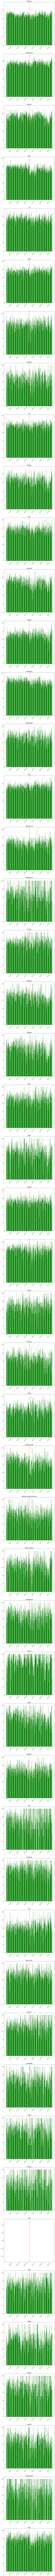

In [96]:
fig, axs = plt.subplots(len(list(col_dict.keys())), 1, figsize = (10, 510))

for i in  range(len(list(col_dict.keys()))): 
    col = list(col_dict.keys())[i]
    tmp_df = deletedQTags_pivot[col].copy()
    tmp_df['tot_cnt'] = tmp_df.sum(axis = 1)
    tmp_df['deletedwithinamonth_r'] = tmp_df[1]/tmp_df['tot_cnt']*100
    tmp_df.fillna(0, inplace=True)

    axs[i].bar(tmp_df.index, tmp_df['deletedwithinamonth_r']  , color='green', label = 'rate of deleted answers in a month ')
    axs[i].tick_params(axis='x', rotation=45)
    axs[i].set_title(col, fontsize = 15)

    axs[i].axvline(['2023-06-01'], # add vertical line
           color = 'red',
           linestyle = '--',
           linewidth = 1.5)
    



In [97]:
[x[0] for x in deletedATags_pivot.columns]

['amazon_web_services',
 'amazon_web_services',
 'android',
 'android',
 'angular',
 'angular',
 'arrays',
 'arrays',
 'azure',
 'azure',
 'c',
 'c',
 'c#',
 'c#',
 'cplusplus',
 'cplusplus',
 'css',
 'css',
 'dart',
 'dart',
 'dataframe',
 'dataframe',
 'django',
 'django',
 'docker',
 'docker',
 'excel',
 'excel',
 'firebase',
 'firebase',
 'flutter',
 'flutter',
 'html',
 'html',
 'ios',
 'ios',
 'java',
 'java',
 'javascript',
 'javascript',
 'jquery',
 'jquery',
 'json',
 'json',
 'kotlin',
 'kotlin',
 'laravel',
 'laravel',
 'linux',
 'linux',
 'list',
 'list',
 'mongodb',
 'mongodb',
 'mysql',
 'mysql',
 'net',
 'net',
 'nodejs',
 'nodejs',
 'numpy',
 'numpy',
 'pandas',
 'pandas',
 'php',
 'php',
 'postgresql',
 'postgresql',
 'powershell',
 'powershell',
 'python',
 'python',
 'python_3x',
 'python_3x',
 'r',
 'r',
 'react_native',
 'react_native',
 'reactjs',
 'reactjs',
 'regex',
 'regex',
 'spring',
 'spring',
 'spring_boot',
 'spring_boot',
 'sql',
 'sql',
 'sql_server',
 

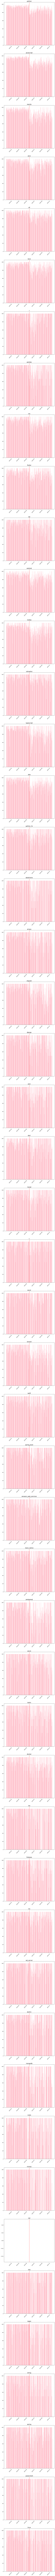

In [98]:
fig, axs = plt.subplots(len(list(col_dict.keys())), 1, figsize = (10, 510))

for i in  range(len(list(col_dict.keys()))): 
    col = list(col_dict.keys())[i]
    tmp_df = deletedATags_pivot[col].copy()
    tmp_df['tot_cnt'] = tmp_df.sum(axis = 1)
    tmp_df['deletedwithinamonth_r'] = tmp_df[1]/tmp_df['tot_cnt']*100
    tmp_df.fillna(0, inplace=True)
    axs[i].bar(tmp_df.index, tmp_df['deletedwithinamonth_r']  , color='pink', label = 'rate of deleted answers in a month ')
    axs[i].tick_params(axis='x', rotation=45)
    axs[i].set_title(col, fontsize = 15)

    axs[i].axvline(['2023-06-01'], # add vertical line
           color = 'red',
           linestyle = '--',
           linewidth = 1.5)

In [99]:
tmp_df


deletedwithinamonth,0,1,tot_cnt,deletedwithinamonth_r
cdate,,,,
2022-11-30,2.0,5.0,7.0,71.428571
2022-12-01,0.0,6.0,6.0,100.000000
2022-12-02,0.0,4.0,4.0,100.000000
2022-12-03,0.0,5.0,5.0,100.000000
2022-12-04,0.0,14.0,14.0,100.000000
...,...,...,...,...
2023-11-25,0.0,3.0,3.0,100.000000
2023-11-26,0.0,3.0,3.0,100.000000
2023-11-27,1.0,1.0,2.0,50.000000


In [100]:
deletedQTags['tot_cnt'] = deletedQTags.iloc[:, 2:].sum(axis = 1)

In [101]:
deletedQTagsTotCnt = deletedQTags.groupby(['cdate']).sum()[['tot_cnt']].reset_index()

In [102]:
deletedQTagsCnt = deletedQTags.loc[deletedQTags['deletedwithinamonth'] ==1, ['cdate', 'tot_cnt']]

In [103]:
deletedQTagsTotCnt = pd.merge(deletedQTagsTotCnt, deletedQTagsCnt, on = 'cdate')

In [104]:
deletedQTagsTotCnt['tot_rate'] = deletedQTagsTotCnt['tot_cnt_y']/deletedQTagsTotCnt['tot_cnt_x']*100

In [105]:
deletedQTagsTotCnt

,cdate,tot_cnt_x,tot_cnt_y,tot_rate
0,2022-11-30,2551,1943,76.166209
1,2022-12-01,2544,1893,74.410377
2,2022-12-02,2278,1619,71.071115
3,2022-12-03,1753,1269,72.390188
4,2022-12-04,1869,1341,71.749599
...,...,...,...,...
360,2023-11-25,827,663,80.169287
361,2023-11-26,819,665,81.196581
362,2023-11-27,1214,906,74.629325
363,2023-11-28,1297,989,76.252891


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


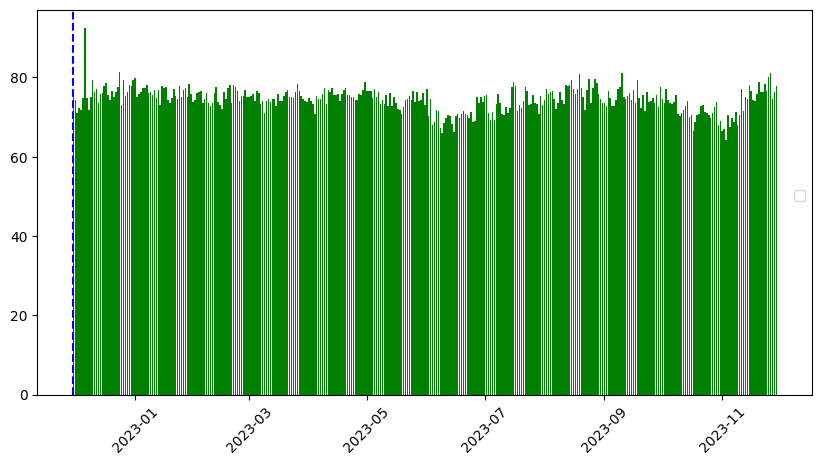

In [106]:
### PrdeletedATags_pivotoblem 2b: Reformat the data and generate the stacked bar plot above.


fig, ax = plt.subplots(figsize = (10, 5))

# ax.bar(topic_per_pivot['date'], topic_per_pivot[0], width = 0.5, color='blue', label = 'Party A')
ax.bar(deletedQTagsTotCnt.cdate, deletedQTagsTotCnt['tot_rate']  , color='green')


ax.axvline([major_xticks[-2]], # add vertical line
           color = 'blue',
           linestyle = '--',
           linewidth = 1.5)

ax.legend( title_fontsize = 10, fontsize = 10,
          bbox_to_anchor = (1, 0.55))

plt.xticks(rotation = 45)
plt.show();

In [107]:
sum(deletedQTags.iloc[:, 2:].sum(axis = 1))

1035086

In [108]:
500491
466838

466838